In [3]:
import os
os.environ['CUDA_VISIBLE_DEVICES'] = '0'
import cv2
import numpy as np

import torch
import torch.nn.functional as F
from ctpn_model import CTPN_Model
from ctpn_utils import gen_anchor, bbox_transfor_inv, clip_box, filter_bbox,nms, TextProposalConnectorOriented
from ctpn_utils import resize
import config

import matplotlib.pyplot as plt
import pandas as pd

In [7]:
prob_thresh = 0.5
width = 960
device = torch.device('cuda:0' if torch.cuda.is_available() else 'cpu')
# weights = '/remote-home/my/final/Code/OCR-code(CTPN+CRNN+CTC Loss)-baidu/checkpoints/v3_ctpn_ep22_0.4395_0.1096_0.5491.pth'#'ctpn_ep17_0.0544_0.1125_0.1669.pth')
weights = '/remote-home/my/final/Code/OCR-code(CTPN+CRNN+CTC Loss)-baidu/CTPN.pth'

model = CTPN_Model()
model.load_state_dict(torch.load(weights, map_location=device)['model_state_dict'])
model.to(device)
model.eval()


def dis(image):
    cv2.imshow('image', image)
    cv2.waitKey(0)
    cv2.destroyAllWindows()


def get_det_boxes(image,display = True):
#     image = resize(image, height=720)
    image_c = image.copy()
    h, w = image.shape[:2]
    image = image.astype(np.float32) - config.IMAGE_MEAN
    image = torch.from_numpy(image.transpose(2, 0, 1)).unsqueeze(0).float()

    with torch.no_grad():
        image = image.to(device)
        cls, regr = model(image)
        cls_prob = F.softmax(cls, dim=-1).cpu().numpy()
        regr = regr.cpu().numpy()
        anchor = gen_anchor((int(h / 16), int(w / 16)), 16)
        bbox = bbox_transfor_inv(anchor, regr)
        bbox = clip_box(bbox, [h, w])
        # print(bbox.shape)

        fg = np.where(cls_prob[0, :, 1] > prob_thresh)[0]
        # print(np.max(cls_prob[0, :, 1]))
        select_anchor = bbox[fg, :]
        select_score = cls_prob[0, fg, 1]
        select_anchor = select_anchor.astype(np.int32)
        # print(select_anchor.shape)
        keep_index = filter_bbox(select_anchor, 16)

        # nms
        select_anchor = select_anchor[keep_index]
        select_score = select_score[keep_index]
        select_score = np.reshape(select_score, (select_score.shape[0], 1))
        nmsbox = np.hstack((select_anchor, select_score))
        keep = nms(nmsbox, 0.3)
        # print(keep)
        select_anchor = select_anchor[keep]
        select_score = select_score[keep]

        # text line-
        textConn = TextProposalConnectorOriented()
        text = textConn.get_text_lines(select_anchor, select_score, [h, w])
#         print(text)
        if display:
            for i in text:
                s = str(round(i[-1] * 100, 2)) + '%'
                i = [int(j) for j in i]
                cv2.line(image_c, (i[0], i[1]), (i[2], i[3]), (0, 0, 255), 2)
                cv2.line(image_c, (i[0], i[1]), (i[4], i[5]), (0, 0, 255), 2)
                cv2.line(image_c, (i[6], i[7]), (i[2], i[3]), (0, 0, 255), 2)
                cv2.line(image_c, (i[4], i[5]), (i[6], i[7]), (0, 0, 255), 2)
#                 cv2.putText(image_c, s, (i[0]+13, i[1]+13),
#                             cv2.FONT_HERSHEY_SIMPLEX,
#                             1,
#                             (255,0,0),
#                             2,
#                             cv2.LINE_AA)
                

        return text,image_c

In [5]:
# 计算IOU

import numpy as np 
import shapely
from shapely.geometry import Polygon,MultiPoint  #多边形
 
def cal_iou(line1,line2):
    # line1=[908,215,934,312,752,355,728,252]   #四边形四个点坐标的一维数组表示，[x,y,x,y....]
    a=np.array(line1).reshape(4, 2)   #四边形二维坐标表示
    poly1 = Polygon(a).convex_hull  #python四边形对象，会自动计算四个点，最后四个点顺序为：左上 左下  右下 右上 左上

    # line2=[923,308,758,342,741,262,907,228]
    b=np.array(line2).reshape(4, 2)
    poly2 = Polygon(b).convex_hull

    union_poly = np.concatenate((a,b))   #合并两个box坐标，变为8*2

    if not poly1.intersects(poly2): #如果两四边形不相交
        iou = 0
    else:
        try:
            inter_area = poly1.intersection(poly2).area   #相交面积
    #         print(inter_area)
            #union_area = poly1.area + poly2.area - inter_area
            union_area = MultiPoint(union_poly).convex_hull.area
    #         print(union_area)
            if union_area == 0:
                iou= 0
            #iou = float(inter_area) / (union_area-inter_area)  #错了
            iou=float(inter_area) / union_area
    #         iou=float(inter_area) /(poly1.area+poly2.area-inter_area)
            # 源码中给出了两种IOU计算方式，第一种计算的是: 交集部分/包含两个四边形最小多边形的面积  
            # 第二种： 交集 / 并集（常见矩形框IOU计算方式） 
        except shapely.geos.TopologicalError:
            print('shapely.geos.TopologicalError occured, iou set to 0')
            iou = 0

    # print(a) 
#     print(iou)
    return iou

In [13]:
if __name__ == '__main__':
    img_path = 'images/t1.jpg'
    image = cv2.imread(img_path)
    text,image = get_det_boxes(image)
    cv2.imwrite('images/t1--.jpg',image)
    # dis(image)

[[1.11000000e+02 5.35414728e+02 1.07464363e+03 5.76765038e+02
  1.07356368e+02 6.20327340e+02 1.07100000e+03 6.61677650e+02
  9.68652368e-01]
 [8.31000000e+02 1.86563725e+02 1.11227132e+03 2.02764399e+02
  8.21728676e+02 3.47529715e+02 1.10300000e+03 3.63730389e+02
  9.74040747e-01]
 [4.33159078e+01 1.76716860e+02 7.83000000e+02 1.58742228e+02
  4.70000000e+01 3.28322984e+02 7.86684092e+02 3.10348351e+02
  9.93308544e-01]
 [4.70000000e+01 3.25635157e+02 1.11022041e+03 3.63455026e+02
  3.97795888e+01 5.28620751e+02 1.10300000e+03 5.66440620e+02
  9.48898375e-01]]


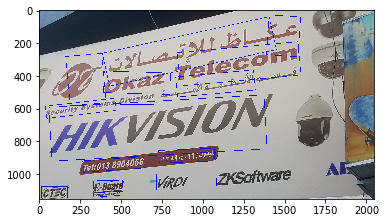

In [8]:
img_path = '/remote-home/my/final/train/img/tr_img_00001.jpg'
image = cv2.imread(img_path)
# print(image.shape)
text,image_after = get_det_boxes(image)
plt.imshow(image_after)

In [1]:
image_after

NameError: name 'image_after' is not defined

In [74]:
x0 = int(np.min(text[0][0:8:2]))
x1 = int(np.max(text[0][0:8:2]))
y0 = int(np.min(text[0][1:8:2]))
y1 = int(np.max(text[0][1:8:2]))

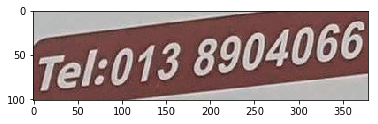

In [77]:
cropped = image[y0:y1, x0:x1]  # 裁剪坐标为[y0:y1, x0:x1]
cv2.imwrite("./test_crop/tr_img_00001_0.jpg", cropped)

plt.imshow(cropped)

In [86]:
txt = pd.read_csv("/remote-home/my/final/train/gt/tr_img_00001.txt",header=None)
img_path = '/remote-home/my/final/train/img/tr_img_00001.jpg'
image = cv2.imread(img_path)
text,image_after = get_det_boxes(image)

for j in range(len(text)):
    label = False
    for i in range(len(txt)):
        gt = list(txt.iloc[i][0:8])
        iou = cal_iou(text[j][0:8],gt)
        if iou > 0.5:
            print(j)

3
4
5
10


In [19]:
!rm -r test_crop
!mkdir test_crop

In [20]:
num = 0

df = pd.DataFrame()
for jpg in range(80,10000):
    torch.cuda.empty_cache()

    if os.path.exists("/remote-home/my/final/test/gt/tr_img_"+ str(jpg).zfill(5)+".txt"):
        print("tr_img_"+ str(jpg).zfill(5))
        txt = pd.read_csv("/remote-home/my/final/test/gt/tr_img_"+ str(jpg).zfill(5)+".txt",header=None,error_bad_lines=False)
        img_path = '/remote-home/my/final/test/img/tr_img_'+ str(jpg).zfill(5)+".jpg"
        image = cv2.imread(img_path)
        text,image_after = get_det_boxes(image)
        dfnew = pd.DataFrame(text)
        dfnew["origin_jpg"] = str(jpg).zfill(5)+".jpg"
        dfnew["index"] = dfnew.index
        
        df = pd.concat([df, dfnew], axis=0)
        for j in range(len(text)):
            torch.cuda.empty_cache()
            label = False
            
            x0 = int(np.min(text[j][0:8:2]))
            x1 = int(np.max(text[j][0:8:2]))
            y0 = int(np.min(text[j][1:8:2]))
            y1 = int(np.max(text[j][1:8:2]))

            cropped = image[y0:y1, x0:x1]  # 裁剪坐标为[y0:y1, x0:x1]
            cv2.imwrite("./test_crop/tr_img_"+ str(jpg).zfill(5)+"_"+str(j).zfill(2)+".jpg", cropped)

            for i in range(len(txt)):
                torch.cuda.empty_cache()
                gt = list(txt.iloc[i][0:8])
                iou = cal_iou(text[j][0:8],gt)
                if iou > 0.5:
                    print(j)
                    num += 1

In [9]:
# iou 合适的

iou_num = 0
txt_num = 0
pred_num = 0
df = pd.DataFrame()
iou_num_list = []
txt_num_list = []
pred_num_list = []

val_img_dir = "/remote-home/my/final/train/img-val/"
val_gt_dir = "/remote-home/my/final/train/gt-val/"

# df_record_num = pd.DataFrame(columns = ['iou_num','txt_num','pred_num'])

for idx in range(len(os.listdir(val_img_dir))):
    jpg = os.listdir(val_img_dir)[idx]
    txtname = jpg.replace("jpg","txt")
    
    torch.cuda.empty_cache()

#     print(val_gt_dir + txtname)
    txt = pd.read_csv(val_gt_dir + txtname,header=None,error_bad_lines=False)
    txt_num += len(txt)
    image = cv2.imread(val_img_dir+jpg)
    
    try:
        text,image_after = get_det_boxes(image)
    except:
        
        print("cuda error")
        torch.cuda.empty_cache()
        continue
    pred_num += len(text)
    
    dfnew = pd.DataFrame(text)
    dfnew["origin_jpg"] = str(jpg).zfill(5)+".jpg"
    dfnew["index"] = dfnew.index

    df = pd.concat([df, dfnew], axis=0)
    for j in range(len(text)):
        torch.cuda.empty_cache()
        for i in range(len(txt)):
            torch.cuda.empty_cache()
            gt = list(txt.iloc[i][0:8])
            iou = cal_iou(text[j][0:8],gt)
            if iou > 0.5:
#                 print(j)
                iou_num += 1
    iou_num_list.append(iou_num)
    txt_num_list.append(txt_num)
    pred_num_list.append(pred_num)
    print(iou_num,txt_num,pred_num)

0 3 2
0 5 6
0 7 7
1 17 11


b'Skipping line 17: expected 10 fields, saw 11\nSkipping line 37: expected 10 fields, saw 11\n'


3 105 42
23 130 65
25 135 68
30 148 75
31 151 77
33 210 82
34 212 84
39 219 90
40 221 93
47 235 103
47 236 105
49 243 109
53 248 113
53 253 117
58 267 125
59 269 127
60 272 129
61 281 132
62 285 134
64 289 136
65 290 138


b'Skipping line 3: expected 10 fields, saw 11\nSkipping line 5: expected 10 fields, saw 11\n'


65 293 140
67 295 142
71 351 150
73 353 152
73 360 154


b'Skipping line 4: expected 10 fields, saw 11\n'


74 381 155
86 410 172
87 415 174
87 420 179
90 469 215
93 480 220
93 489 222
95 493 225
96 502 234
96 504 234
98 509 237
100 518 240
100 519 240
101 520 241
103 527 243
104 533 245
104 534 245
105 535 249


b'Skipping line 4: expected 10 fields, saw 11\n'


111 543 261
111 544 261
111 571 262
111 574 263
117 582 271
117 583 276
119 589 278
120 595 280
125 627 300
126 631 304
126 643 306
130 647 310
133 651 313
134 655 315
135 656 316
136 694 321
137 696 322
139 698 324


b'Skipping line 8: expected 10 fields, saw 11\nSkipping line 9: expected 10 fields, saw 11\nSkipping line 15: expected 10 fields, saw 11\n'


146 710 340
147 711 341
147 719 342
147 720 342
167 796 394
167 799 395


b'Skipping line 2: expected 10 fields, saw 11\n'


169 821 401
171 824 404
174 828 408


b'Skipping line 8: expected 10 fields, saw 11\n'


175 841 411
175 846 412
177 848 414
178 861 416
180 867 421
180 873 421
180 876 423
181 879 427
185 883 431
190 888 436
191 889 437
191 898 439
191 907 440
192 908 441
197 952 459
198 963 464
200 965 467
202 970 469
202 992 494
207 1007 499
207 1012 500
210 1017 503
212 1025 506
217 1075 522
219 1081 525
220 1088 528
221 1089 529
224 1092 532
227 1096 554
230 1099 557
235 1104 563
237 1108 566
237 1126 569
238 1151 589
240 1155 595
241 1160 597
244 1168 601
244 1170 602
250 1176 608
253 1179 611
254 1183 612
254 1189 613
258 1196 619
258 1197 620
258 1201 621
263 1224 631
266 1229 634
268 1237 637
272 1243 642
272 1244 644
274 1247 647
275 1251 649
289 1270 664
290 1272 665
290 1280 666
290 1281 666
292 1284 668
293 1287 672
293 1289 673
294 1291 674
297 1307 679
297 1312 680
297 1339 681
306 1349 690
306 1353 690
308 1399 699
308 1403 700
309 1409 701
312 1414 713
314 1418 716
314 1420 716
317 1424 720
319 1440 730
319 1442 732
320 1449 734
322 1455 742
322 1462 742
326 1489 750
328 1

b'Skipping line 4: expected 10 fields, saw 11\n'


328 1497 754
328 1502 755
336 1515 768
339 1524 773
342 1529 776
343 1530 777
344 1531 778
344 1534 783
346 1537 786
346 1540 786
347 1542 788
350 1547 814
351 1557 817
352 1559 818
352 1564 823
352 1570 825
352 1574 826
355 1595 833
355 1597 834
355 1609 836
356 1612 840
361 1652 849
361 1659 851
361 1661 854
363 1669 856
364 1670 857
364 1695 857
368 1700 866
369 1703 871


b'Skipping line 5: expected 10 fields, saw 11\n'


369 1712 873
374 1724 878
382 1737 887
384 1746 891
386 1750 899
386 1776 902
387 1781 904
387 1784 908
387 1790 909
387 1795 910
390 1799 913
391 1807 916
394 1810 919
394 1813 921
395 1818 922
398 1821 926
401 1832 932
401 1834 932
403 1839 946
406 1852 953
409 1857 956
410 1861 961
415 1866 971
416 1889 975
417 1890 976
417 1934 979


b'Skipping line 31: expected 10 fields, saw 11\nSkipping line 62: expected 10 fields, saw 11\nSkipping line 68: expected 10 fields, saw 11\n'


417 2005 986
425 2025 998
425 2026 1000
428 2034 1015
431 2037 1018
432 2039 1020
432 2047 1024
441 2057 1033
441 2074 1035
451 2086 1048
453 2091 1053
455 2093 1055
456 2094 1056
456 2099 1057
459 2104 1063
463 2111 1067
465 2115 1070
465 2135 1074
465 2137 1075
465 2140 1077
465 2145 1077
465 2148 1078
465 2150 1080


b'Skipping line 10: expected 10 fields, saw 11\nSkipping line 20: expected 10 fields, saw 12\n'


478 2204 1118
480 2208 1121
481 2212 1123
482 2215 1129


b'Skipping line 41: expected 10 fields, saw 11\nSkipping line 42: expected 10 fields, saw 11\n'


488 2256 1144
488 2262 1146
490 2264 1149
494 2269 1153
495 2270 1154
497 2276 1157
506 2332 1177
507 2337 1178
507 2340 1181
508 2341 1182


b'Skipping line 12: expected 10 fields, saw 11\n'


510 2367 1188
533 2396 1213
535 2404 1219
538 2408 1223
542 2443 1230
542 2446 1236
544 2448 1238
544 2453 1240
548 2458 1248
550 2462 1253
553 2468 1256
554 2490 1262
562 2506 1276


b'Skipping line 28: expected 10 fields, saw 11\n'


581 2582 1311
583 2584 1320
583 2606 1325
583 2612 1346
587 2626 1355
588 2627 1356
591 2642 1362


b'Skipping line 7: expected 10 fields, saw 11\n'
b'Skipping line 5: expected 10 fields, saw 11\nSkipping line 9: expected 10 fields, saw 11\n'


591 2649 1365
592 2651 1366
593 2654 1369
593 2657 1369
597 2665 1378
598 2667 1379
600 2673 1384
603 2679 1387
603 2683 1388
603 2698 1392


b'Skipping line 2: expected 10 fields, saw 11\n'


603 2706 1400
608 2712 1406
608 2713 1408
611 2723 1413
615 2727 1417
615 2730 1418
617 2734 1420
617 2737 1433
618 2743 1436
618 2749 1436
619 2750 1437
621 2753 1440
622 2757 1441
625 2763 1445
628 2769 1448
628 2772 1449
630 2774 1451
631 2808 1463
633 2810 1465
636 2821 1472
637 2828 1473
639 2847 1476
640 2852 1477
640 2855 1484
642 2859 1490
644 2863 1503
645 2865 1505
647 2869 1507
649 2875 1510
650 2878 1512
650 2879 1522
651 2882 1524
651 2887 1525
655 2904 1535
660 2911 1550
660 3070 1551
662 3075 1553
668 3081 1561


b'Skipping line 10: expected 10 fields, saw 11\nSkipping line 11: expected 10 fields, saw 11\nSkipping line 29: expected 10 fields, saw 11\n'


677 3118 1575
678 3121 1576
678 3137 1581
679 3139 1583
680 3140 1584
680 3143 1585
681 3145 1586
682 3149 1589
684 3153 1592
684 3156 1599
686 3159 1601


b'Skipping line 2: expected 10 fields, saw 11\n'


689 3162 1611
691 3166 1614
691 3167 1618
696 3197 1633
696 3204 1636
698 3221 1643
698 3223 1644
699 3226 1646
699 3229 1647
701 3235 1651
703 3239 1653
705 3244 1655
708 3248 1658
708 3289 1663
708 3297 1663
712 3307 1672
713 3311 1673
713 3313 1674
715 3320 1710
715 3329 1713
715 3331 1715
716 3332 1716
718 3344 1723
720 3347 1727
724 3459 1736
726 3467 1739
727 3469 1740
727 3472 1741
729 3476 1744
733 3480 1748
738 3486 1753
741 3509 1756
744 3517 1760
746 3521 1763
748 3526 1767
749 3534 1770
757 3550 1782
757 3553 1785
757 3558 1786
760 3561 1792
761 3562 1796
761 3574 1799
762 3576 1803
763 3577 1804
764 3578 1805
769 3597 1814
774 3674 1847
776 3680 1849
776 3687 1853
779 3697 1860
779 3699 1861
779 3704 1861
779 3708 1863
779 3714 1864
780 3718 1866
781 3726 1868
781 3734 1869
785 3738 1873
786 3742 1875
789 3749 1879
789 3760 1881
789 3766 1883


b'Skipping line 7: expected 10 fields, saw 11\n'


791 3768 1885
795 3803 1893
796 3813 1896
796 3820 1899
823 4034 1967
826 4037 1972
828 4044 1976


b'Skipping line 14: expected 10 fields, saw 11\nSkipping line 15: expected 10 fields, saw 11\n'


838 4065 1993
839 4079 1995
839 4084 1996
843 4090 2002
845 4092 2004
847 4113 2008


b'Skipping line 6: expected 10 fields, saw 11\nSkipping line 8: expected 10 fields, saw 11\n'


848 4121 2011
849 4123 2013


b'Skipping line 2: expected 10 fields, saw 11\n'


850 4125 2017
850 4130 2020
850 4132 2021
850 4134 2022
852 4140 2025
862 4169 2047
863 4170 2048
864 4197 2057
864 4198 2057
865 4202 2066
865 4208 2067
868 4212 2072
871 4218 2075
873 4226 2085
873 4228 2085
874 4235 2088
875 4239 2094
875 4241 2094
876 4242 2095
879 4271 2103
879 4275 2104
881 4277 2106
883 4280 2108
884 4288 2111
887 4292 2123
887 4294 2124
888 4296 2125
891 4302 2134
897 4349 2149
902 4388 2155
904 4394 2159
907 4400 2165
907 4406 2167
911 4418 2173
914 4422 2178
919 4430 2184
922 4433 2187
923 4439 2189


b'Skipping line 2: expected 10 fields, saw 11\nSkipping line 5: expected 10 fields, saw 11\n'


926 4444 2197
927 4445 2199
927 4453 2201
927 4459 2202


b'Skipping line 2: expected 10 fields, saw 11\n'


928 4463 2203
935 4506 2211
942 4517 2220
942 4520 2221
945 4523 2224


b'Skipping line 12: expected 10 fields, saw 11\n'


947 4534 2231
952 4566 2242
952 4568 2243
962 4579 2253
963 4580 2254
969 4588 2263
973 4593 2267
974 4597 2270
978 4618 2281
980 4621 2283
980 4623 2305
983 4634 2311
988 4643 2325
989 4654 2328
1001 4714 2353
1001 4716 2354
1004 4723 2362
1005 4732 2363


b'Skipping line 7: expected 10 fields, saw 11\n'


1006 4744 2367
1008 4749 2369
1012 4755 2373
1013 4757 2375
1020 4781 2387
1023 4786 2396
1023 4793 2398
1024 4796 2400
1027 4810 2407
1029 4824 2413
1036 4870 2429
1038 4875 2433
1038 4893 2445
1038 4896 2450
1038 4900 2451
1039 4902 2455
1046 4922 2463
1048 4924 2465
1049 4932 2468
1056 4941 2475
1056 4942 2475
1056 4947 2476
1057 4949 2477
1057 4951 2478
1058 4954 2480
1060 4978 2483
1062 4985 2486
1066 4997 2493
1066 4999 2494
1069 5023 2502
1070 5028 2505
1073 5038 2512
1074 5044 2515
1075 5053 2518
1079 5057 2522
1088 5068 2533
1089 5070 2540
1089 5071 2540
1096 5088 2549
1097 5091 2550
1099 5093 2552
1100 5099 2554
1104 5119 2561
1104 5123 2562


b'Skipping line 2: expected 10 fields, saw 11\n'


1108 5127 2567
1108 5131 2568
1110 5133 2570
1112 5138 2573


b'Skipping line 4: expected 10 fields, saw 11\n'


1112 5144 2576
1113 5152 2579
1114 5153 2580
1122 5178 2596
1123 5180 2598
1124 5182 2599


b'Skipping line 3: expected 10 fields, saw 11\n'


1126 5206 2601
1127 5215 2605
1129 5241 2609
1130 5247 2610
1131 5250 2611
1135 5272 2617
1135 5276 2620
1135 5281 2622
1135 5282 2622
1137 5284 2624
1142 5297 2634
1144 5299 2636
1151 5307 2645
1152 5316 2657
1155 5320 2663
1155 5322 2668
1161 5329 2676
1163 5336 2679
1163 5337 2679
1164 5343 2681
1165 5344 2682
1169 5399 2694
1169 5411 2709
1171 5414 2711
1173 5448 2720
1177 5458 2727
1177 5465 2728
1179 5469 2731
1183 5473 2735
1183 5476 2736
1184 5481 2739
1184 5486 2740


b'Skipping line 5: expected 10 fields, saw 11\n'


1200 5518 2779


b'Skipping line 33: expected 10 fields, saw 11\nSkipping line 36: expected 10 fields, saw 11\n'


1207 5571 2796
1208 5573 2799
1208 5575 2799
1213 5585 2812
1213 5588 2812


b'Skipping line 14: expected 10 fields, saw 11\n'


1217 5602 2820
1220 5625 2825
1221 5629 2827


b'Skipping line 9: expected 10 fields, saw 11\n'


1223 5642 2831
1225 5644 2836
1226 5645 2837
1234 5687 2846
1235 5690 2848
1244 5704 2860
1247 5716 2865
1249 5718 2868
1250 5721 2873
1250 5724 2874
1251 5728 2876
1254 5737 2880
1255 5738 2881
1255 5742 2882
1256 5745 2884
1258 5747 2886
1260 5749 2888


b'Skipping line 50: expected 10 fields, saw 11\n'


1270 5807 2913
1271 5812 2917
1271 5813 2917
1278 5823 2925
1282 5830 2932
1283 5832 2934
1284 5845 2938
1285 5850 2945


b'Skipping line 3: expected 10 fields, saw 11\n'


1289 5855 2951
1292 5862 2966
1294 5868 2969
1297 5873 2972
1297 5877 2973
1311 5927 3000
1312 5936 3003
1312 5941 3006
1313 5943 3008


b'Skipping line 63: expected 10 fields, saw 11\n'


1320 6014 3033
1320 6023 3034
1325 6047 3045
1326 6053 3047
1327 6059 3049
1330 6067 3053
1332 6076 3055


b'Skipping line 53: expected 10 fields, saw 11\nSkipping line 61: expected 10 fields, saw 11\nSkipping line 105: expected 10 fields, saw 11\nSkipping line 106: expected 10 fields, saw 11\nSkipping line 108: expected 10 fields, saw 11\n'


1347 6190 3098
1349 6192 3100
1349 6200 3102
1354 6208 3110
1354 6221 3112
1354 6225 3114
1354 6229 3115


b'Skipping line 8: expected 10 fields, saw 11\n'


1358 6243 3127
1358 6244 3127
1360 6253 3131
1360 6259 3133
1361 6260 3134
1362 6262 3136


b'Skipping line 9: expected 10 fields, saw 11\nSkipping line 20: expected 10 fields, saw 11\nSkipping line 22: expected 10 fields, saw 11\n'


1370 6293 3170
1373 6315 3175
1373 6319 3177
1374 6340 3189
1377 6343 3192
1378 6344 3194


b'Skipping line 2: expected 10 fields, saw 11\n'


1379 6350 3196
1382 6357 3201
1384 6361 3204
1386 6393 3210
1387 6398 3213
1389 6402 3218


b'Skipping line 30: expected 10 fields, saw 12\nSkipping line 32: expected 10 fields, saw 11\nSkipping line 92: expected 10 fields, saw 11\nSkipping line 103: expected 10 fields, saw 11\n'


1427 6537 3291
1430 6548 3296
1430 6555 3297
1434 6561 3301


b'Skipping line 4: expected 10 fields, saw 11\n'


1436 6565 3305
1439 6570 3309
1440 6577 3311


b'Skipping line 24: expected 10 fields, saw 11\n'


1447 6639 3337
1452 6666 3346


b'Skipping line 161: expected 10 fields, saw 11\n'


1506 6828 3428
1506 6831 3429
1511 6843 3459
1511 6849 3461
1518 6880 3471
1518 6883 3473
1520 6885 3475
1522 6890 3478
1522 6892 3479
1522 6895 3481
1522 6897 3482
1524 6900 3485
1524 6917 3495
1525 6921 3497
1529 6928 3501
1530 6929 3502
1531 6931 3503
1532 6933 3504
1533 6975 3512
1534 6978 3517
1535 6980 3518
1535 6983 3519
1535 6988 3522
1535 6991 3525
1536 6995 3527


b'Skipping line 16: expected 10 fields, saw 11\n'


1549 7012 3546
1549 7013 3547
1549 7021 3555


b'Skipping line 12: expected 10 fields, saw 11\n'


1556 7038 3570
1558 7050 3577
1562 7059 3585
1564 7068 3588
1565 7074 3589
1569 7080 3595
1569 7083 3596


b'Skipping line 3: expected 10 fields, saw 11\n'


1576 7092 3603
1576 7095 3605
1577 7106 3609
1579 7115 3613
1587 7133 3629
1588 7142 3631
1589 7204 3633
1589 7206 3634
1601 7362 3663
1602 7367 3665
1602 7368 3667
1604 7370 3673
1606 7373 3683
1606 7384 3685
1608 7392 3693
1612 7400 3699
1613 7403 3702
1616 7406 3705
1618 7423 3715
1618 7424 3716
1619 7431 3717
1620 7437 3720
1620 7445 3722
1621 7446 3723
1624 7455 3728
1632 7494 3740
1633 7504 3743
1633 7513 3745
1634 7516 3748
1635 7531 3749
1635 7541 3752
1638 7544 3755
1638 7555 3757
1639 7557 3758
1641 7559 3760
1641 7564 3762
1641 7566 3764
1644 7569 3767
1646 7575 3769
1647 7581 3772
1647 7585 3773
1650 7595 3777
1651 7598 3779
1653 7601 3782
1654 7604 3784
1657 7611 3788
1658 7612 3789
1660 7626 3803
1660 7632 3805
1661 7636 3807
1666 7642 3817
1666 7643 3821
1666 7647 3823
1666 7658 3825
1680 7718 3848
1691 7732 3874
1693 7734 3876
1694 7744 3878
1694 7750 3879
1694 7751 3880
1698 7758 3889


b'Skipping line 22: expected 10 fields, saw 11\nSkipping line 25: expected 10 fields, saw 11\n'


1709 7783 3909
1711 7787 3911
1713 7792 3914
1716 7800 3917
1716 7802 3918
1718 7806 3922
1738 7836 3944
1742 7841 3953
1746 7848 3957
1746 7851 3961
1750 7876 3971
1753 7880 3974
1753 7883 3981
1754 7885 3982
1757 7889 3985
1757 7896 3987
1759 7899 3989
1759 7904 3990


b'Skipping line 27: expected 10 fields, saw 11\nSkipping line 28: expected 10 fields, saw 11\n'


1768 7940 4007
1769 7944 4010
1770 7956 4012
1771 7975 4018
1774 7988 4024
1775 7990 4037
1776 7993 4038
1781 8022 4045
1781 8026 4054
1781 8038 4056
1783 8040 4058
1787 8045 4062
1791 8049 4069
1792 8084 4081
1792 8092 4086
1792 8099 4088
1795 8106 4094
1799 8110 4098
1810 8131 4114
1812 8134 4116
1813 8141 4124
1819 8188 4138
1821 8194 4141
1821 8195 4141
1822 8200 4144
1828 8212 4154
1828 8214 4155
1830 8230 4165
1831 8239 4169
1839 8251 4189
1841 8254 4196
1842 8255 4197
1844 8281 4206
1846 8285 4209
1849 8288 4212
1854 8294 4217
1857 8300 4221
1861 8306 4226
1862 8330 4232
1866 8348 4241
1867 8351 4243
1869 8356 4247


In [10]:
df_record_num = pd.DataFrame()
df_record_num["iou_num"]=iou_num_list
df_record_num["txt_num"]=txt_num_list
df_record_num["pred_num"]=pred_num_list
df_record_num.to_csv("df_record_num.txt")

In [7]:
# 裁剪test的图片
# df = pd.DataFrame()
for jpg in range(1480,10000):
    if os.path.exists("/remote-home/my/final/test/img/tr_img_"+ str(jpg).zfill(5)+".jpg"):
        print("tr_img_"+ str(jpg).zfill(5))
#         txt = pd.read_csv("/remote-home/my/final/test/gt/tr_img_"+ str(jpg).zfill(5)+".txt",header=None,error_bad_lines=False)
        img_path = '/remote-home/my/final/test/img/tr_img_'+ str(jpg).zfill(5)+".jpg"
        image = cv2.imread(img_path)
        torch.cuda.empty_cache()
        try:
            text,image_after = get_det_boxes(image)
        except:
            print("cuda error")
            torch.cuda.empty_cache()
            continue
        dfnew = pd.DataFrame(text)
        dfnew["origin_jpg"] = str(jpg).zfill(5)+".jpg"
        dfnew["index"] = dfnew.index
        
        df = pd.concat([df, dfnew], axis=0)
        df.to_csv("test_crop.txt",sep=",",index=False)
        for j in range(len(text)):
            torch.cuda.empty_cache()
            
            x0 = int(np.min(text[j][0:8:2]))
            x1 = int(np.max(text[j][0:8:2]))
            y0 = int(np.min(text[j][1:8:2]))
            y1 = int(np.max(text[j][1:8:2]))

            cropped = image[y0:y1, x0:x1]  # 裁剪坐标为[y0:y1, x0:x1]
            cv2.imwrite("./test_crop/tr_img_"+ str(jpg).zfill(5)+"_"+str(j).zfill(2)+".jpg", cropped)

tr_img_01480
cuda error
tr_img_01481
tr_img_01482
tr_img_01483
tr_img_01484
tr_img_01485
tr_img_01486
tr_img_01487
tr_img_01488
cuda error
tr_img_01489
tr_img_01490
tr_img_01491
tr_img_01492
tr_img_01493
tr_img_01494
tr_img_01495
tr_img_01496
tr_img_01497
tr_img_01498
tr_img_01499
cuda error
tr_img_01580
tr_img_01581
tr_img_01582
tr_img_01583
tr_img_01584
tr_img_01585
tr_img_01586
tr_img_01587
tr_img_01588
tr_img_01589
tr_img_01590
cuda error
tr_img_01591
tr_img_01592
tr_img_01593
tr_img_01594
tr_img_01595
tr_img_01596
tr_img_01597
tr_img_01598
tr_img_01599
tr_img_01680
cuda error
tr_img_01681
tr_img_01682
tr_img_01683
tr_img_01684
tr_img_01685
tr_img_01686
tr_img_01687
tr_img_01688
tr_img_01689
tr_img_01690
tr_img_01691
tr_img_01692
tr_img_01693
tr_img_01694
tr_img_01695
tr_img_01696
tr_img_01697
tr_img_01698
tr_img_01699
tr_img_01780
tr_img_01781
tr_img_01782
tr_img_01783
tr_img_01784
tr_img_01785
tr_img_01786
tr_img_01787
tr_img_01788
tr_img_01789
tr_img_01790
tr_img_01791
tr_img_01

tr_img_04388
cuda error
tr_img_04389
tr_img_04390
cuda error
tr_img_04391
cuda error
tr_img_04392
cuda error
tr_img_04393
cuda error
tr_img_04394
cuda error
tr_img_04395
tr_img_04396
cuda error
tr_img_04397
cuda error
tr_img_04398
tr_img_04399
cuda error
tr_img_04480
cuda error
tr_img_04481
cuda error
tr_img_04482
tr_img_04483
cuda error
tr_img_04484
tr_img_04485
tr_img_04486
cuda error
tr_img_04487
cuda error
tr_img_04488
tr_img_04489
cuda error
tr_img_04490
cuda error
tr_img_04491
tr_img_04492
cuda error
tr_img_04493
cuda error
tr_img_04494
tr_img_04495
cuda error
tr_img_04496
cuda error
tr_img_04497
tr_img_04498
tr_img_04499
cuda error
tr_img_04580
tr_img_04581
cuda error
tr_img_04582
cuda error
tr_img_04583
tr_img_04584
cuda error
tr_img_04585
tr_img_04586
cuda error
tr_img_04587
tr_img_04588
tr_img_04589
tr_img_04590
cuda error
tr_img_04591
tr_img_04592
cuda error
tr_img_04593
cuda error
tr_img_04594
tr_img_04595
cuda error
tr_img_04596
cuda error
tr_img_04597
tr_img_04598
cuda er

tr_img_06987
tr_img_06988
tr_img_06989
tr_img_06990
tr_img_06991
tr_img_06992
cuda error
tr_img_06993
tr_img_06994
tr_img_06995
tr_img_06996
tr_img_06997
tr_img_06998
tr_img_06999
tr_img_07080
tr_img_07081
cuda error
tr_img_07082
tr_img_07083
cuda error
tr_img_07084
tr_img_07085
tr_img_07086
cuda error
tr_img_07087
tr_img_07088
tr_img_07089
tr_img_07090
tr_img_07091
tr_img_07092
tr_img_07093
tr_img_07094
cuda error
tr_img_07095
cuda error
tr_img_07096
tr_img_07097
tr_img_07098
tr_img_07099
tr_img_07180
tr_img_07181
tr_img_07182
tr_img_07183
tr_img_07184
cuda error
tr_img_07185
tr_img_07186
cuda error
tr_img_07187
tr_img_07188
cuda error
tr_img_07189
tr_img_07190
tr_img_07191
tr_img_07192
tr_img_07193
tr_img_07194
cuda error
tr_img_07195
cuda error
tr_img_07196
tr_img_07197
tr_img_07198
cuda error
tr_img_07199
tr_img_07280
tr_img_07281
cuda error
tr_img_07282
tr_img_07283
tr_img_07284
cuda error
tr_img_07285
cuda error
tr_img_07286
tr_img_07287
tr_img_07288
tr_img_07289
cuda error
tr_im

tr_img_09894
tr_img_09895
tr_img_09896
tr_img_09897
tr_img_09898
tr_img_09899
tr_img_09980
tr_img_09981
tr_img_09982
tr_img_09983
tr_img_09984
tr_img_09985
tr_img_09986
tr_img_09987
tr_img_09988
tr_img_09989
tr_img_09990
tr_img_09991
tr_img_09993
tr_img_09994
tr_img_09995
tr_img_09996
tr_img_09997
tr_img_09998
tr_img_09999


In [11]:
len(os.listdir("test_crop"))

8944

In [13]:
!zip -r test_crop.zip test_crop

  adding: test_crop/ (stored 0%)
  adding: test_crop/tr_img_07182_06.jpg (deflated 2%)
  adding: test_crop/tr_img_02298_02.jpg (deflated 0%)
  adding: test_crop/tr_img_06081_09.jpg (deflated 2%)
  adding: test_crop/tr_img_03391_07.jpg (deflated 7%)
  adding: test_crop/tr_img_02997_00.jpg (deflated 0%)
  adding: test_crop/tr_img_05794_10.jpg (deflated 2%)
  adding: test_crop/tr_img_06998_02.jpg (deflated 1%)
  adding: test_crop/tr_img_06092_08.jpg (deflated 1%)
  adding: test_crop/tr_img_03993_04.jpg (deflated 1%)
  adding: test_crop/tr_img_01785_00.jpg (deflated 2%)
  adding: test_crop/tr_img_03193_03.jpg (stored 0%)
  adding: test_crop/tr_img_03196_08.jpg (deflated 1%)
  adding: test_crop/tr_img_00988_02.jpg (deflated 0%)
  adding: test_crop/tr_img_06185_34.jpg (deflated 4%)
  adding: test_crop/tr_img_06590_01.jpg (deflated 1%)
  adding: test_crop/tr_img_03083_08.jpg (deflated 2%)
  adding: test_crop/tr_img_07596_28.jpg (deflated 3%)
  adding: test_crop/tr_img_00185_01.jpg (deflated 4

  adding: test_crop/tr_img_07092_01.jpg (deflated 0%)
  adding: test_crop/tr_img_07199_35.jpg (deflated 5%)
  adding: test_crop/tr_img_06883_06.jpg (deflated 2%)
  adding: test_crop/tr_img_06184_00.jpg (deflated 2%)
  adding: test_crop/tr_img_02087_04.jpg (deflated 0%)
  adding: test_crop/tr_img_02182_05.jpg (deflated 0%)
  adding: test_crop/tr_img_07498_16.jpg (deflated 1%)
  adding: test_crop/tr_img_07891_34.jpg (deflated 15%)
  adding: test_crop/tr_img_01388_00.jpg (deflated 1%)
  adding: test_crop/tr_img_08390_11.jpg (deflated 1%)
  adding: test_crop/tr_img_05293_03.jpg (deflated 9%)
  adding: test_crop/tr_img_02586_00.jpg (deflated 0%)
  adding: test_crop/tr_img_08081_00.jpg (deflated 1%)
  adding: test_crop/tr_img_06488_08.jpg (deflated 2%)
  adding: test_crop/tr_img_03381_05.jpg (deflated 1%)
  adding: test_crop/tr_img_04597_08.jpg (deflated 4%)
  adding: test_crop/tr_img_08088_11.jpg (deflated 2%)
  adding: test_crop/tr_img_09194_01.jpg (deflated 2%)
  adding: test_crop/tr_img_

  adding: test_crop/tr_img_06485_00.jpg (deflated 1%)
  adding: test_crop/tr_img_09692_00.jpg (deflated 1%)
  adding: test_crop/tr_img_02382_03.jpg (deflated 4%)
  adding: test_crop/tr_img_07498_03.jpg (deflated 1%)
  adding: test_crop/tr_img_03285_01.jpg (deflated 2%)
  adding: test_crop/tr_img_06397_05.jpg (deflated 3%)
  adding: test_crop/tr_img_01695_00.jpg (deflated 2%)
  adding: test_crop/tr_img_05693_07.jpg (deflated 4%)
  adding: test_crop/tr_img_08195_02.jpg (deflated 0%)
  adding: test_crop/tr_img_07193_02.jpg (deflated 1%)
  adding: test_crop/tr_img_04097_01.jpg (deflated 1%)
  adding: test_crop/tr_img_05599_11.jpg (deflated 1%)
  adding: test_crop/tr_img_07985_05.jpg (deflated 1%)
  adding: test_crop/tr_img_09893_01.jpg (deflated 2%)
  adding: test_crop/tr_img_07398_02.jpg (deflated 3%)
  adding: test_crop/tr_img_04580_08.jpg (deflated 4%)
  adding: test_crop/tr_img_06983_04.jpg (deflated 4%)
  adding: test_crop/tr_img_04789_04.jpg (deflated 0%)
  adding: test_crop/tr_img_0

  adding: test_crop/tr_img_07992_13.jpg (deflated 8%)
  adding: test_crop/tr_img_03789_00.jpg (deflated 1%)
  adding: test_crop/tr_img_06190_13.jpg (deflated 1%)
  adding: test_crop/tr_img_02882_04.jpg (deflated 0%)
  adding: test_crop/tr_img_06081_01.jpg (deflated 0%)
  adding: test_crop/tr_img_02695_14.jpg (deflated 4%)
  adding: test_crop/tr_img_06694_02.jpg (deflated 3%)
  adding: test_crop/tr_img_05995_02.jpg (deflated 1%)
  adding: test_crop/tr_img_01091_03.jpg (deflated 2%)
  adding: test_crop/tr_img_03195_04.jpg (deflated 2%)
  adding: test_crop/tr_img_07891_06.jpg (deflated 7%)
  adding: test_crop/tr_img_09095_02.jpg (deflated 2%)
  adding: test_crop/tr_img_06182_05.jpg (deflated 2%)
  adding: test_crop/tr_img_05093_00.jpg (deflated 1%)
  adding: test_crop/tr_img_01795_01.jpg (deflated 5%)
  adding: test_crop/tr_img_02381_03.jpg (deflated 2%)
  adding: test_crop/tr_img_04981_06.jpg (deflated 1%)
  adding: test_crop/tr_img_05297_01.jpg (deflated 1%)
  adding: test_crop/tr_img_0

  adding: test_crop/tr_img_05086_13.jpg (deflated 2%)
  adding: test_crop/tr_img_04594_00.jpg (deflated 7%)
  adding: test_crop/tr_img_06983_10.jpg (deflated 7%)
  adding: test_crop/tr_img_04985_00.jpg (deflated 1%)
  adding: test_crop/tr_img_00387_02.jpg (deflated 7%)
  adding: test_crop/tr_img_03281_12.jpg (deflated 5%)
  adding: test_crop/tr_img_04389_12.jpg (deflated 14%)
  adding: test_crop/tr_img_05097_06.jpg (deflated 0%)
  adding: test_crop/tr_img_07187_15.jpg (deflated 2%)
  adding: test_crop/tr_img_07887_00.jpg (deflated 2%)
  adding: test_crop/tr_img_05385_02.jpg (deflated 0%)
  adding: test_crop/tr_img_02297_00.jpg (deflated 2%)
  adding: test_crop/tr_img_06293_04.jpg (deflated 1%)
  adding: test_crop/tr_img_04389_19.jpg (deflated 11%)
  adding: test_crop/tr_img_02791_00.jpg (deflated 2%)
  adding: test_crop/tr_img_09687_00.jpg (deflated 2%)
  adding: test_crop/tr_img_04587_07.jpg (deflated 0%)
  adding: test_crop/tr_img_07596_11.jpg (deflated 3%)
  adding: test_crop/tr_img

  adding: test_crop/tr_img_05484_01.jpg (deflated 1%)
  adding: test_crop/tr_img_07088_08.jpg (deflated 1%)
  adding: test_crop/tr_img_05085_04.jpg (deflated 2%)
  adding: test_crop/tr_img_07394_14.jpg (deflated 18%)
  adding: test_crop/tr_img_00196_03.jpg (deflated 7%)
  adding: test_crop/tr_img_08583_01.jpg (deflated 0%)
  adding: test_crop/tr_img_06390_00.jpg (deflated 1%)
  adding: test_crop/tr_img_08091_01.jpg (deflated 0%)
  adding: test_crop/tr_img_04189_10.jpg (deflated 1%)
  adding: test_crop/tr_img_06597_01.jpg (deflated 3%)
  adding: test_crop/tr_img_07982_06.jpg (deflated 2%)
  adding: test_crop/tr_img_04789_03.jpg (deflated 1%)
  adding: test_crop/tr_img_09181_01.jpg (deflated 1%)
  adding: test_crop/tr_img_01494_02.jpg (deflated 2%)
  adding: test_crop/tr_img_00097_13.jpg (deflated 5%)
  adding: test_crop/tr_img_04587_03.jpg (deflated 0%)
  adding: test_crop/tr_img_07692_00.jpg (deflated 3%)
  adding: test_crop/tr_img_05898_02.jpg (deflated 1%)
  adding: test_crop/tr_img_

  adding: test_crop/tr_img_05981_01.jpg (deflated 1%)
  adding: test_crop/tr_img_06486_00.jpg (deflated 1%)
  adding: test_crop/tr_img_07299_00.jpg (deflated 0%)
  adding: test_crop/tr_img_08992_01.jpg (deflated 3%)
  adding: test_crop/tr_img_04597_05.jpg (deflated 1%)
  adding: test_crop/tr_img_00091_02.jpg (deflated 1%)
  adding: test_crop/tr_img_05487_03.jpg (deflated 0%)
  adding: test_crop/tr_img_02590_00.jpg (deflated 1%)
  adding: test_crop/tr_img_04398_05.jpg (deflated 0%)
  adding: test_crop/tr_img_07189_02.jpg (deflated 1%)
  adding: test_crop/tr_img_06480_07.jpg (deflated 2%)
  adding: test_crop/tr_img_07187_19.jpg (deflated 2%)
  adding: test_crop/tr_img_04484_02.jpg (deflated 2%)
  adding: test_crop/tr_img_00581_02.jpg (deflated 6%)
  adding: test_crop/tr_img_06283_02.jpg (deflated 6%)
  adding: test_crop/tr_img_07486_01.jpg (deflated 0%)
  adding: test_crop/tr_img_04892_05.jpg (deflated 1%)
  adding: test_crop/tr_img_07596_29.jpg (deflated 5%)
  adding: test_crop/tr_img_0

  adding: test_crop/tr_img_06595_00.jpg (deflated 1%)
  adding: test_crop/tr_img_06081_08.jpg (deflated 2%)
  adding: test_crop/tr_img_04694_00.jpg (deflated 0%)
  adding: test_crop/tr_img_05591_07.jpg (deflated 0%)
  adding: test_crop/tr_img_07192_06.jpg (deflated 5%)
  adding: test_crop/tr_img_07597_02.jpg (deflated 1%)
  adding: test_crop/tr_img_07389_03.jpg (deflated 3%)
  adding: test_crop/tr_img_01489_01.jpg (deflated 2%)
  adding: test_crop/tr_img_05793_01.jpg (deflated 2%)
  adding: test_crop/tr_img_08390_08.jpg (deflated 3%)
  adding: test_crop/tr_img_04989_02.jpg (deflated 1%)
  adding: test_crop/tr_img_00493_04.jpg (deflated 3%)
  adding: test_crop/tr_img_06998_00.jpg (deflated 1%)
  adding: test_crop/tr_img_07288_03.jpg (deflated 2%)
  adding: test_crop/tr_img_05880_03.jpg (deflated 9%)
  adding: test_crop/tr_img_06980_02.jpg (deflated 7%)
  adding: test_crop/tr_img_02197_05.jpg (deflated 4%)
  adding: test_crop/tr_img_07280_01.jpg (deflated 3%)
  adding: test_crop/tr_img_0

  adding: test_crop/tr_img_07590_26.jpg (deflated 1%)
  adding: test_crop/tr_img_08780_00.jpg (deflated 0%)
  adding: test_crop/tr_img_06883_11.jpg (deflated 3%)
  adding: test_crop/tr_img_05393_04.jpg (deflated 2%)
  adding: test_crop/tr_img_06684_00.jpg (deflated 1%)
  adding: test_crop/tr_img_08091_07.jpg (deflated 8%)
  adding: test_crop/tr_img_01095_02.jpg (deflated 6%)
  adding: test_crop/tr_img_00783_02.jpg (deflated 9%)
  adding: test_crop/tr_img_07581_12.jpg (deflated 4%)
  adding: test_crop/tr_img_06792_01.jpg (deflated 5%)
  adding: test_crop/tr_img_08685_01.jpg (deflated 1%)
  adding: test_crop/tr_img_00091_03.jpg (deflated 2%)
  adding: test_crop/tr_img_06190_15.jpg (deflated 4%)
  adding: test_crop/tr_img_07885_04.jpg (deflated 4%)
  adding: test_crop/tr_img_06695_02.jpg (deflated 0%)
  adding: test_crop/tr_img_02582_00.jpg (deflated 1%)
  adding: test_crop/tr_img_05691_02.jpg (deflated 1%)
  adding: test_crop/tr_img_04189_32.jpg (deflated 20%)
  adding: test_crop/tr_img_

  adding: test_crop/tr_img_05183_16.jpg (deflated 1%)
  adding: test_crop/tr_img_02687_03.jpg (deflated 1%)
  adding: test_crop/tr_img_06982_64.jpg (deflated 4%)
  adding: test_crop/tr_img_00289_00.jpg (deflated 1%)
  adding: test_crop/tr_img_03687_03.jpg (deflated 4%)
  adding: test_crop/tr_img_07891_04.jpg (deflated 3%)
  adding: test_crop/tr_img_07097_05.jpg (deflated 3%)
  adding: test_crop/tr_img_07991_02.jpg (deflated 2%)
  adding: test_crop/tr_img_00996_01.jpg (deflated 3%)
  adding: test_crop/tr_img_08882_00.jpg (deflated 1%)
  adding: test_crop/tr_img_01988_01.jpg (deflated 0%)
  adding: test_crop/tr_img_06299_00.jpg (deflated 4%)
  adding: test_crop/tr_img_06097_09.jpg (deflated 0%)
  adding: test_crop/tr_img_00097_09.jpg (deflated 3%)
  adding: test_crop/tr_img_04398_10.jpg (deflated 1%)
  adding: test_crop/tr_img_01580_04.jpg (deflated 2%)
  adding: test_crop/tr_img_06389_05.jpg (deflated 3%)
  adding: test_crop/tr_img_03898_07.jpg (deflated 3%)
  adding: test_crop/tr_img_0

  adding: test_crop/tr_img_08689_00.jpg (deflated 1%)
  adding: test_crop/tr_img_00097_06.jpg (deflated 2%)
  adding: test_crop/tr_img_03497_00.jpg (deflated 1%)
  adding: test_crop/tr_img_08298_01.jpg (deflated 2%)
  adding: test_crop/tr_img_06196_09.jpg (deflated 0%)
  adding: test_crop/tr_img_06387_05.jpg (deflated 2%)
  adding: test_crop/tr_img_06982_45.jpg (deflated 2%)
  adding: test_crop/tr_img_09482_00.jpg (deflated 4%)
  adding: test_crop/tr_img_05998_01.jpg (deflated 1%)
  adding: test_crop/tr_img_03282_01.jpg (deflated 0%)
  adding: test_crop/tr_img_07187_04.jpg (deflated 3%)
  adding: test_crop/tr_img_06795_01.jpg (deflated 2%)
  adding: test_crop/tr_img_04884_04.jpg (deflated 7%)
  adding: test_crop/tr_img_02698_08.jpg (deflated 5%)
  adding: test_crop/tr_img_02084_03.jpg (deflated 0%)
  adding: test_crop/tr_img_09294_00.jpg (deflated 3%)
  adding: test_crop/tr_img_03591_14.jpg (deflated 1%)
  adding: test_crop/tr_img_07588_07.jpg (deflated 7%)
  adding: test_crop/tr_img_0

  adding: test_crop/tr_img_08390_03.jpg (deflated 1%)
  adding: test_crop/tr_img_05387_01.jpg (deflated 2%)
  adding: test_crop/tr_img_03896_11.jpg (deflated 7%)
  adding: test_crop/tr_img_07199_37.jpg (deflated 5%)
  adding: test_crop/tr_img_00088_00.jpg (deflated 8%)
  adding: test_crop/tr_img_04981_15.jpg (deflated 1%)
  adding: test_crop/tr_img_06896_08.jpg (deflated 1%)
  adding: test_crop/tr_img_08888_01.jpg (deflated 0%)
  adding: test_crop/tr_img_02593_01.jpg (deflated 3%)
  adding: test_crop/tr_img_03898_12.jpg (deflated 3%)
  adding: test_crop/tr_img_08581_02.jpg (deflated 1%)
  adding: test_crop/tr_img_02794_00.jpg (deflated 1%)
  adding: test_crop/tr_img_03896_07.jpg (deflated 1%)
  adding: test_crop/tr_img_05296_04.jpg (deflated 2%)
  adding: test_crop/tr_img_06394_04.jpg (deflated 2%)
  adding: test_crop/tr_img_09187_00.jpg (deflated 2%)
  adding: test_crop/tr_img_02299_19.jpg (deflated 2%)
  adding: test_crop/tr_img_06593_01.jpg (deflated 0%)
  adding: test_crop/tr_img_0

  adding: test_crop/tr_img_03492_12.jpg (deflated 2%)
  adding: test_crop/tr_img_08793_00.jpg (deflated 1%)
  adding: test_crop/tr_img_08480_03.jpg (deflated 5%)
  adding: test_crop/tr_img_07885_15.jpg (deflated 2%)
  adding: test_crop/tr_img_06292_03.jpg (deflated 1%)
  adding: test_crop/tr_img_06995_03.jpg (deflated 2%)
  adding: test_crop/tr_img_05784_07.jpg (deflated 1%)
  adding: test_crop/tr_img_09688_00.jpg (deflated 1%)
  adding: test_crop/tr_img_09198_00.jpg (deflated 2%)
  adding: test_crop/tr_img_07695_07.jpg (deflated 19%)
  adding: test_crop/tr_img_05981_03.jpg (deflated 1%)
  adding: test_crop/tr_img_09986_02.jpg (deflated 0%)
  adding: test_crop/tr_img_07089_05.jpg (deflated 0%)
  adding: test_crop/tr_img_05486_03.jpg (deflated 1%)
  adding: test_crop/tr_img_07997_01.jpg (deflated 1%)
  adding: test_crop/tr_img_05493_03.jpg (deflated 5%)
  adding: test_crop/tr_img_02894_03.jpg (deflated 1%)
  adding: test_crop/tr_img_06887_00.jpg (deflated 0%)
  adding: test_crop/tr_img_

  adding: test_crop/tr_img_06482_07.jpg (deflated 0%)
  adding: test_crop/tr_img_03083_14.jpg (deflated 2%)
  adding: test_crop/tr_img_05283_08.jpg (stored 0%)
  adding: test_crop/tr_img_07889_05.jpg (deflated 2%)
  adding: test_crop/tr_img_02988_04.jpg (deflated 1%)
  adding: test_crop/tr_img_06982_28.jpg (deflated 4%)
  adding: test_crop/tr_img_06981_01.jpg (deflated 3%)
  adding: test_crop/tr_img_06489_06.jpg (deflated 1%)
  adding: test_crop/tr_img_07597_05.jpg (deflated 3%)
  adding: test_crop/tr_img_03591_09.jpg (deflated 1%)
  adding: test_crop/tr_img_02289_01.jpg (deflated 1%)
  adding: test_crop/tr_img_05685_01.jpg (deflated 0%)
  adding: test_crop/tr_img_08091_03.jpg (deflated 0%)
  adding: test_crop/tr_img_02394_01.jpg (deflated 0%)
  adding: test_crop/tr_img_05190_03.jpg (deflated 0%)
  adding: test_crop/tr_img_00990_03.jpg (deflated 3%)
  adding: test_crop/tr_img_04289_01.jpg (deflated 1%)
  adding: test_crop/tr_img_05983_08.jpg (deflated 3%)
  adding: test_crop/tr_img_070

  adding: test_crop/tr_img_08094_00.jpg (deflated 1%)
  adding: test_crop/tr_img_06482_09.jpg (deflated 3%)
  adding: test_crop/tr_img_06982_56.jpg (deflated 11%)
  adding: test_crop/tr_img_00689_01.jpg (deflated 2%)
  adding: test_crop/tr_img_02292_00.jpg (deflated 0%)
  adding: test_crop/tr_img_07181_00.jpg (deflated 3%)
  adding: test_crop/tr_img_00895_00.jpg (deflated 6%)
  adding: test_crop/tr_img_04484_01.jpg (deflated 6%)
  adding: test_crop/tr_img_06997_00.jpg (deflated 0%)
  adding: test_crop/tr_img_01080_07.jpg (deflated 7%)
  adding: test_crop/tr_img_00883_03.jpg (deflated 4%)
  adding: test_crop/tr_img_01181_00.jpg (deflated 6%)
  adding: test_crop/tr_img_07590_05.jpg (deflated 1%)
  adding: test_crop/tr_img_00486_01.jpg (deflated 4%)
  adding: test_crop/tr_img_06996_01.jpg (deflated 7%)
  adding: test_crop/tr_img_03096_00.jpg (deflated 2%)
  adding: test_crop/tr_img_04083_13.jpg (deflated 8%)
  adding: test_crop/tr_img_04987_06.jpg (deflated 1%)
  adding: test_crop/tr_img_

  adding: test_crop/tr_img_07891_28.jpg (deflated 7%)
  adding: test_crop/tr_img_04683_05.jpg (deflated 2%)
  adding: test_crop/tr_img_03482_03.jpg (deflated 0%)
  adding: test_crop/tr_img_02092_00.jpg (deflated 1%)
  adding: test_crop/tr_img_08881_02.jpg (deflated 2%)
  adding: test_crop/tr_img_05189_08.jpg (deflated 0%)
  adding: test_crop/tr_img_03987_01.jpg (deflated 1%)
  adding: test_crop/tr_img_01797_00.jpg (deflated 3%)
  adding: test_crop/tr_img_04185_14.jpg (deflated 2%)
  adding: test_crop/tr_img_06495_06.jpg (deflated 5%)
  adding: test_crop/tr_img_03088_14.jpg (deflated 3%)
  adding: test_crop/tr_img_03682_06.jpg (deflated 3%)
  adding: test_crop/tr_img_05686_13.jpg (deflated 1%)
  adding: test_crop/tr_img_03797_02.jpg (deflated 5%)
  adding: test_crop/tr_img_06383_01.jpg (deflated 11%)
  adding: test_crop/tr_img_04083_10.jpg (deflated 3%)
  adding: test_crop/tr_img_04494_03.jpg (deflated 0%)
  adding: test_crop/tr_img_00882_01.jpg (deflated 1%)
  adding: test_crop/tr_img_

  adding: test_crop/tr_img_03890_03.jpg (deflated 1%)
  adding: test_crop/tr_img_00791_02.jpg (deflated 1%)
  adding: test_crop/tr_img_00985_04.jpg (deflated 1%)
  adding: test_crop/tr_img_05680_03.jpg (deflated 0%)
  adding: test_crop/tr_img_03388_00.jpg (deflated 1%)
  adding: test_crop/tr_img_01298_00.jpg (deflated 2%)
  adding: test_crop/tr_img_02788_00.jpg (deflated 1%)
  adding: test_crop/tr_img_07497_39.jpg (deflated 2%)
  adding: test_crop/tr_img_05386_04.jpg (deflated 1%)
  adding: test_crop/tr_img_02194_02.jpg (deflated 1%)
  adding: test_crop/tr_img_04281_07.jpg (deflated 2%)
  adding: test_crop/tr_img_06580_04.jpg (deflated 7%)
  adding: test_crop/tr_img_04587_16.jpg (deflated 1%)
  adding: test_crop/tr_img_04986_05.jpg (deflated 0%)
  adding: test_crop/tr_img_06592_02.jpg (deflated 3%)
  adding: test_crop/tr_img_00587_10.jpg (deflated 1%)
  adding: test_crop/tr_img_06585_17.jpg (deflated 1%)
  adding: test_crop/tr_img_09099_02.jpg (deflated 1%)
  adding: test_crop/tr_img_0

  adding: test_crop/tr_img_05287_09.jpg (deflated 0%)
  adding: test_crop/tr_img_08591_05.jpg (deflated 1%)
  adding: test_crop/tr_img_00982_02.jpg (deflated 3%)
  adding: test_crop/tr_img_04883_02.jpg (deflated 0%)
  adding: test_crop/tr_img_05389_10.jpg (deflated 0%)
  adding: test_crop/tr_img_03996_08.jpg (deflated 3%)
  adding: test_crop/tr_img_02292_01.jpg (deflated 1%)
  adding: test_crop/tr_img_06995_05.jpg (deflated 4%)
  adding: test_crop/tr_img_09898_06.jpg (deflated 1%)
  adding: test_crop/tr_img_04386_01.jpg (deflated 4%)
  adding: test_crop/tr_img_02299_38.jpg (deflated 4%)
  adding: test_crop/tr_img_07096_11.jpg (deflated 2%)
  adding: test_crop/tr_img_05294_02.jpg (deflated 1%)
  adding: test_crop/tr_img_00493_08.jpg (deflated 1%)
  adding: test_crop/tr_img_07084_03.jpg (deflated 4%)
  adding: test_crop/tr_img_02381_02.jpg (deflated 2%)
  adding: test_crop/tr_img_07992_00.jpg (deflated 4%)
  adding: test_crop/tr_img_04086_01.jpg (deflated 0%)
  adding: test_crop/tr_img_0

  adding: test_crop/tr_img_08181_06.jpg (deflated 0%)
  adding: test_crop/tr_img_02993_02.jpg (deflated 3%)
  adding: test_crop/tr_img_05295_01.jpg (deflated 1%)
  adding: test_crop/tr_img_03383_03.jpg (deflated 1%)
  adding: test_crop/tr_img_03088_12.jpg (deflated 3%)
  adding: test_crop/tr_img_06490_04.jpg (deflated 1%)
  adding: test_crop/tr_img_07385_02.jpg (deflated 2%)
  adding: test_crop/tr_img_06198_06.jpg (deflated 2%)
  adding: test_crop/tr_img_00984_06.jpg (deflated 1%)
  adding: test_crop/tr_img_02599_13.jpg (deflated 3%)
  adding: test_crop/tr_img_05199_00.jpg (deflated 1%)
  adding: test_crop/tr_img_06397_13.jpg (deflated 9%)
  adding: test_crop/tr_img_04398_18.jpg (deflated 1%)
  adding: test_crop/tr_img_01799_00.jpg (deflated 2%)
  adding: test_crop/tr_img_06392_12.jpg (deflated 8%)
  adding: test_crop/tr_img_03682_03.jpg (deflated 2%)
  adding: test_crop/tr_img_07986_04.jpg (deflated 1%)
  adding: test_crop/tr_img_08890_01.jpg (deflated 1%)
  adding: test_crop/tr_img_0

  adding: test_crop/tr_img_08393_01.jpg (deflated 0%)
  adding: test_crop/tr_img_08281_00.jpg (deflated 0%)
  adding: test_crop/tr_img_08387_01.jpg (stored 0%)
  adding: test_crop/tr_img_09082_01.jpg (deflated 4%)
  adding: test_crop/tr_img_02387_03.jpg (deflated 2%)
  adding: test_crop/tr_img_06481_02.jpg (deflated 5%)
  adding: test_crop/tr_img_06884_13.jpg (deflated 0%)
  adding: test_crop/tr_img_07498_00.jpg (deflated 0%)
  adding: test_crop/tr_img_01988_00.jpg (deflated 1%)
  adding: test_crop/tr_img_01182_10.jpg (deflated 1%)
  adding: test_crop/tr_img_01191_00.jpg (deflated 2%)
  adding: test_crop/tr_img_03881_00.jpg (deflated 1%)
  adding: test_crop/tr_img_05494_05.jpg (deflated 5%)
  adding: test_crop/tr_img_07788_06.jpg (deflated 5%)
  adding: test_crop/tr_img_07187_51.jpg (deflated 4%)
  adding: test_crop/tr_img_08590_00.jpg (deflated 2%)
  adding: test_crop/tr_img_05795_04.jpg (deflated 2%)
  adding: test_crop/tr_img_07187_80.jpg (deflated 10%)
  adding: test_crop/tr_img_01

  adding: test_crop/tr_img_07488_05.jpg (deflated 1%)
  adding: test_crop/tr_img_07688_01.jpg (deflated 8%)
  adding: test_crop/tr_img_05493_01.jpg (deflated 1%)
  adding: test_crop/tr_img_05497_05.jpg (deflated 0%)
  adding: test_crop/tr_img_07387_06.jpg (deflated 1%)
  adding: test_crop/tr_img_06983_01.jpg (deflated 3%)
  adding: test_crop/tr_img_09384_02.jpg (deflated 11%)
  adding: test_crop/tr_img_02781_04.jpg (deflated 1%)
  adding: test_crop/tr_img_03688_01.jpg (deflated 3%)
  adding: test_crop/tr_img_03797_01.jpg (deflated 2%)
  adding: test_crop/tr_img_02384_03.jpg (deflated 2%)
  adding: test_crop/tr_img_04597_17.jpg (deflated 0%)
  adding: test_crop/tr_img_07889_07.jpg (deflated 3%)
  adding: test_crop/tr_img_05184_03.jpg (deflated 1%)
  adding: test_crop/tr_img_07187_84.jpg (deflated 11%)
  adding: test_crop/tr_img_00698_00.jpg (deflated 1%)
  adding: test_crop/tr_img_00888_07.jpg (deflated 7%)
  adding: test_crop/tr_img_05599_01.jpg (deflated 1%)
  adding: test_crop/tr_img

  adding: test_crop/tr_img_06482_03.jpg (deflated 0%)
  adding: test_crop/tr_img_06081_00.jpg (deflated 0%)
  adding: test_crop/tr_img_06786_09.jpg (deflated 2%)
  adding: test_crop/tr_img_05881_04.jpg (deflated 2%)
  adding: test_crop/tr_img_05190_08.jpg (deflated 1%)
  adding: test_crop/tr_img_03693_00.jpg (deflated 2%)
  adding: test_crop/tr_img_09288_00.jpg (deflated 1%)
  adding: test_crop/tr_img_05891_04.jpg (deflated 11%)
  adding: test_crop/tr_img_05391_06.jpg (deflated 1%)
  adding: test_crop/tr_img_01595_00.jpg (deflated 4%)
  adding: test_crop/tr_img_05583_00.jpg (deflated 0%)
  adding: test_crop/tr_img_03099_04.jpg (deflated 3%)
  adding: test_crop/tr_img_01997_01.jpg (deflated 7%)
  adding: test_crop/tr_img_06688_02.jpg (deflated 0%)
  adding: test_crop/tr_img_06493_02.jpg (deflated 1%)
  adding: test_crop/tr_img_08094_01.jpg (deflated 1%)
  adding: test_crop/tr_img_08285_03.jpg (deflated 1%)
  adding: test_crop/tr_img_07497_34.jpg (deflated 6%)
  adding: test_crop/tr_img_

  adding: test_crop/tr_img_02491_00.jpg (deflated 0%)
  adding: test_crop/tr_img_09498_00.jpg (deflated 2%)
  adding: test_crop/tr_img_03398_00.jpg (deflated 1%)
  adding: test_crop/tr_img_09797_00.jpg (deflated 1%)
  adding: test_crop/tr_img_01992_00.jpg (deflated 5%)
  adding: test_crop/tr_img_04892_03.jpg (deflated 3%)
  adding: test_crop/tr_img_05692_03.jpg (deflated 1%)
  adding: test_crop/tr_img_03380_09.jpg (deflated 0%)
  adding: test_crop/tr_img_06185_25.jpg (deflated 6%)
  adding: test_crop/tr_img_06982_68.jpg (deflated 1%)
  adding: test_crop/tr_img_04189_19.jpg (deflated 5%)
  adding: test_crop/tr_img_06299_03.jpg (deflated 1%)
  adding: test_crop/tr_img_07497_12.jpg (deflated 4%)
  adding: test_crop/tr_img_00388_01.jpg (deflated 2%)
  adding: test_crop/tr_img_06391_07.jpg (deflated 1%)
  adding: test_crop/tr_img_09195_01.jpg (deflated 1%)
  adding: test_crop/tr_img_06190_21.jpg (deflated 3%)
  adding: test_crop/tr_img_05787_08.jpg (deflated 9%)
  adding: test_crop/tr_img_0

  adding: test_crop/tr_img_03686_06.jpg (deflated 0%)
  adding: test_crop/tr_img_00593_02.jpg (deflated 8%)
  adding: test_crop/tr_img_05195_01.jpg (deflated 1%)
  adding: test_crop/tr_img_05495_00.jpg (deflated 0%)
  adding: test_crop/tr_img_04181_05.jpg (deflated 0%)
  adding: test_crop/tr_img_02992_00.jpg (deflated 1%)
  adding: test_crop/tr_img_01793_03.jpg (deflated 3%)
  adding: test_crop/tr_img_06694_01.jpg (deflated 2%)
  adding: test_crop/tr_img_00596_01.jpg (deflated 5%)
  adding: test_crop/tr_img_02299_22.jpg (deflated 11%)
  adding: test_crop/tr_img_05894_01.jpg (deflated 1%)
  adding: test_crop/tr_img_00392_01.jpg (deflated 1%)
  adding: test_crop/tr_img_02993_00.jpg (deflated 3%)
  adding: test_crop/tr_img_05988_08.jpg (deflated 0%)
  adding: test_crop/tr_img_02882_00.jpg (deflated 3%)
  adding: test_crop/tr_img_06597_02.jpg (deflated 2%)
  adding: test_crop/tr_img_06784_14.jpg (deflated 1%)
  adding: test_crop/tr_img_07087_13.jpg (deflated 1%)
  adding: test_crop/tr_img_

  adding: test_crop/tr_img_02495_00.jpg (deflated 0%)
  adding: test_crop/tr_img_07192_01.jpg (deflated 1%)
  adding: test_crop/tr_img_00192_02.jpg (deflated 3%)
  adding: test_crop/tr_img_05184_08.jpg (deflated 2%)
  adding: test_crop/tr_img_09093_00.jpg (deflated 1%)
  adding: test_crop/tr_img_05286_12.jpg (deflated 1%)
  adding: test_crop/tr_img_03695_00.jpg (deflated 2%)
  adding: test_crop/tr_img_05396_10.jpg (deflated 0%)
  adding: test_crop/tr_img_06185_23.jpg (deflated 3%)
  adding: test_crop/tr_img_09998_00.jpg (deflated 1%)
  adding: test_crop/tr_img_02097_02.jpg (deflated 3%)
  adding: test_crop/tr_img_06698_02.jpg (deflated 2%)
  adding: test_crop/tr_img_08192_00.jpg (deflated 1%)
  adding: test_crop/tr_img_06695_00.jpg (deflated 0%)
  adding: test_crop/tr_img_06494_00.jpg (deflated 3%)
  adding: test_crop/tr_img_06896_22.jpg (deflated 2%)
  adding: test_crop/tr_img_06490_09.jpg (deflated 1%)
  adding: test_crop/tr_img_06189_00.jpg (deflated 1%)
  adding: test_crop/tr_img_0

  adding: test_crop/tr_img_08596_01.jpg (deflated 3%)
  adding: test_crop/tr_img_07595_00.jpg (deflated 0%)
  adding: test_crop/tr_img_06199_12.jpg (deflated 4%)
  adding: test_crop/tr_img_05084_07.jpg (deflated 4%)
  adding: test_crop/tr_img_07092_08.jpg (deflated 1%)
  adding: test_crop/tr_img_02589_00.jpg (deflated 6%)
  adding: test_crop/tr_img_07891_25.jpg (deflated 7%)
  adding: test_crop/tr_img_07498_13.jpg (deflated 4%)
  adding: test_crop/tr_img_04097_00.jpg (deflated 0%)
  adding: test_crop/tr_img_05591_03.jpg (deflated 0%)
  adding: test_crop/tr_img_05998_00.jpg (deflated 7%)
  adding: test_crop/tr_img_03999_00.jpg (deflated 3%)
  adding: test_crop/tr_img_06983_18.jpg (deflated 3%)
  adding: test_crop/tr_img_00183_03.jpg (deflated 1%)
  adding: test_crop/tr_img_08184_01.jpg (deflated 1%)
  adding: test_crop/tr_img_07982_01.jpg (deflated 3%)
  adding: test_crop/tr_img_06683_12.jpg (deflated 3%)
  adding: test_crop/tr_img_02185_00.jpg (deflated 2%)
  adding: test_crop/tr_img_0

  adding: test_crop/tr_img_08887_05.jpg (deflated 0%)
  adding: test_crop/tr_img_01486_01.jpg (deflated 5%)
  adding: test_crop/tr_img_06593_03.jpg (deflated 2%)
  adding: test_crop/tr_img_01399_01.jpg (deflated 4%)
  adding: test_crop/tr_img_06994_02.jpg (deflated 2%)
  adding: test_crop/tr_img_06982_40.jpg (deflated 6%)
  adding: test_crop/tr_img_06889_06.jpg (deflated 2%)
  adding: test_crop/tr_img_01787_01.jpg (deflated 1%)
  adding: test_crop/tr_img_05488_01.jpg (deflated 2%)
  adding: test_crop/tr_img_07191_05.jpg (deflated 4%)
  adding: test_crop/tr_img_07084_07.jpg (deflated 1%)
  adding: test_crop/tr_img_07290_05.jpg (deflated 1%)
  adding: test_crop/tr_img_00387_01.jpg (deflated 6%)
  adding: test_crop/tr_img_05082_00.jpg (deflated 2%)
  adding: test_crop/tr_img_09898_00.jpg (deflated 0%)
  adding: test_crop/tr_img_02883_00.jpg (deflated 1%)
  adding: test_crop/tr_img_06797_00.jpg (deflated 6%)
  adding: test_crop/tr_img_03096_03.jpg (deflated 1%)
  adding: test_crop/tr_img_0

  adding: test_crop/tr_img_06194_00.jpg (deflated 1%)
  adding: test_crop/tr_img_02384_05.jpg (deflated 2%)
  adding: test_crop/tr_img_00583_03.jpg (deflated 2%)
  adding: test_crop/tr_img_01586_04.jpg (deflated 2%)
  adding: test_crop/tr_img_03381_17.jpg (deflated 1%)
  adding: test_crop/tr_img_02596_00.jpg (deflated 5%)
  adding: test_crop/tr_img_07598_06.jpg (deflated 4%)
  adding: test_crop/tr_img_07590_03.jpg (deflated 1%)
  adding: test_crop/tr_img_00888_01.jpg (deflated 5%)
  adding: test_crop/tr_img_07891_19.jpg (deflated 8%)
  adding: test_crop/tr_img_02688_01.jpg (deflated 1%)
  adding: test_crop/tr_img_05188_03.jpg (deflated 0%)
  adding: test_crop/tr_img_08586_07.jpg (deflated 0%)
  adding: test_crop/tr_img_03283_00.jpg (deflated 1%)
  adding: test_crop/tr_img_05782_07.jpg (deflated 0%)
  adding: test_crop/tr_img_02180_00.jpg (deflated 0%)
  adding: test_crop/tr_img_04186_15.jpg (deflated 0%)
  adding: test_crop/tr_img_06690_04.jpg (deflated 3%)
  adding: test_crop/tr_img_0

  adding: test_crop/tr_img_04185_17.jpg (deflated 8%)
  adding: test_crop/tr_img_06884_00.jpg (deflated 2%)
  adding: test_crop/tr_img_07294_05.jpg (deflated 0%)
  adding: test_crop/tr_img_06999_04.jpg (deflated 1%)
  adding: test_crop/tr_img_05688_07.jpg (deflated 4%)
  adding: test_crop/tr_img_01182_03.jpg (deflated 1%)
  adding: test_crop/tr_img_07684_07.jpg (deflated 1%)
  adding: test_crop/tr_img_05585_01.jpg (deflated 1%)
  adding: test_crop/tr_img_05782_06.jpg (deflated 1%)
  adding: test_crop/tr_img_05392_00.jpg (deflated 0%)
  adding: test_crop/tr_img_06480_23.jpg (deflated 1%)
  adding: test_crop/tr_img_03794_00.jpg (deflated 1%)
  adding: test_crop/tr_img_05380_04.jpg (deflated 1%)
  adding: test_crop/tr_img_02387_02.jpg (deflated 1%)
  adding: test_crop/tr_img_07183_08.jpg (deflated 10%)
  adding: test_crop/tr_img_00887_00.jpg (deflated 3%)
  adding: test_crop/tr_img_00582_01.jpg (deflated 4%)
  adding: test_crop/tr_img_02698_11.jpg (deflated 3%)
  adding: test_crop/tr_img_

  adding: test_crop/tr_img_09891_02.jpg (deflated 1%)
  adding: test_crop/tr_img_08492_00.jpg (stored 0%)
  adding: test_crop/tr_img_08580_01.jpg (deflated 1%)
  adding: test_crop/tr_img_03398_02.jpg (deflated 2%)
  adding: test_crop/tr_img_07394_09.jpg (deflated 5%)
  adding: test_crop/tr_img_09191_00.jpg (deflated 1%)
  adding: test_crop/tr_img_06480_26.jpg (deflated 2%)
  adding: test_crop/tr_img_06896_20.jpg (deflated 1%)
  adding: test_crop/tr_img_01784_02.jpg (deflated 4%)
  adding: test_crop/tr_img_06081_12.jpg (deflated 1%)
  adding: test_crop/tr_img_03381_15.jpg (deflated 2%)
  adding: test_crop/tr_img_03598_08.jpg (deflated 2%)
  adding: test_crop/tr_img_07596_36.jpg (deflated 2%)
  adding: test_crop/tr_img_08591_03.jpg (deflated 1%)
  adding: test_crop/tr_img_06485_04.jpg (deflated 1%)
  adding: test_crop/tr_img_04587_09.jpg (deflated 0%)
  adding: test_crop/tr_img_06584_02.jpg (deflated 1%)
  adding: test_crop/tr_img_07290_07.jpg (deflated 1%)
  adding: test_crop/tr_img_028

  adding: test_crop/tr_img_04695_05.jpg (deflated 0%)
  adding: test_crop/tr_img_01798_07.jpg (deflated 10%)
  adding: test_crop/tr_img_06092_03.jpg (deflated 0%)
  adding: test_crop/tr_img_02790_04.jpg (deflated 5%)
  adding: test_crop/tr_img_09192_00.jpg (deflated 1%)
  adding: test_crop/tr_img_05793_03.jpg (deflated 4%)
  adding: test_crop/tr_img_02187_00.jpg (deflated 0%)
  adding: test_crop/tr_img_08890_00.jpg (deflated 2%)
  adding: test_crop/tr_img_01986_00.jpg (deflated 6%)
  adding: test_crop/tr_img_07180_02.jpg (deflated 0%)
  adding: test_crop/tr_img_00688_00.jpg (deflated 2%)
  adding: test_crop/tr_img_08694_02.jpg (deflated 1%)
  adding: test_crop/tr_img_03988_00.jpg (deflated 1%)
  adding: test_crop/tr_img_00591_01.jpg (deflated 3%)
  adding: test_crop/tr_img_01093_00.jpg (deflated 2%)
  adding: test_crop/tr_img_01594_00.jpg (deflated 3%)
  adding: test_crop/tr_img_07099_06.jpg (deflated 1%)
  adding: test_crop/tr_img_03195_00.jpg (deflated 3%)
  adding: test_crop/tr_img_

  adding: test_crop/tr_img_08791_01.jpg (deflated 1%)
  adding: test_crop/tr_img_05189_09.jpg (deflated 1%)
  adding: test_crop/tr_img_07588_10.jpg (deflated 2%)
  adding: test_crop/tr_img_03093_02.jpg (deflated 3%)
  adding: test_crop/tr_img_07588_19.jpg (deflated 1%)
  adding: test_crop/tr_img_06287_02.jpg (deflated 1%)
  adding: test_crop/tr_img_06683_15.jpg (deflated 2%)
  adding: test_crop/tr_img_07985_08.jpg (deflated 4%)
  adding: test_crop/tr_img_06982_08.jpg (deflated 3%)
  adding: test_crop/tr_img_06982_71.jpg (deflated 2%)
  adding: test_crop/tr_img_04497_06.jpg (deflated 0%)
  adding: test_crop/tr_img_03489_00.jpg (deflated 1%)
  adding: test_crop/tr_img_00799_00.jpg (deflated 2%)
  adding: test_crop/tr_img_07495_02.jpg (deflated 6%)
  adding: test_crop/tr_img_05986_00.jpg (deflated 1%)
  adding: test_crop/tr_img_05191_08.jpg (deflated 4%)
  adding: test_crop/tr_img_09884_02.jpg (deflated 1%)
  adding: test_crop/tr_img_07096_08.jpg (deflated 2%)
  adding: test_crop/tr_img_0

  adding: test_crop/tr_img_03083_09.jpg (deflated 2%)
  adding: test_crop/tr_img_07287_03.jpg (deflated 2%)
  adding: test_crop/tr_img_06480_17.jpg (deflated 14%)
  adding: test_crop/tr_img_01893_04.jpg (deflated 3%)
  adding: test_crop/tr_img_06785_06.jpg (deflated 3%)
  adding: test_crop/tr_img_00589_03.jpg (deflated 4%)
  adding: test_crop/tr_img_02182_01.jpg (deflated 1%)
  adding: test_crop/tr_img_08686_01.jpg (deflated 1%)
  adding: test_crop/tr_img_05282_07.jpg (deflated 0%)
  adding: test_crop/tr_img_06286_01.jpg (deflated 2%)
  adding: test_crop/tr_img_08481_00.jpg (deflated 0%)
  adding: test_crop/tr_img_07087_06.jpg (deflated 1%)
  adding: test_crop/tr_img_05988_00.jpg (deflated 3%)
  adding: test_crop/tr_img_05981_04.jpg (deflated 1%)
  adding: test_crop/tr_img_00484_07.jpg (deflated 11%)
  adding: test_crop/tr_img_06588_01.jpg (deflated 1%)
  adding: test_crop/tr_img_07891_24.jpg (deflated 8%)
  adding: test_crop/tr_img_01689_00.jpg (deflated 2%)
  adding: test_crop/tr_img

  adding: test_crop/tr_img_03488_00.jpg (deflated 1%)
  adding: test_crop/tr_img_05385_03.jpg (deflated 1%)
  adding: test_crop/tr_img_06089_02.jpg (deflated 1%)
  adding: test_crop/tr_img_02584_01.jpg (deflated 1%)
  adding: test_crop/tr_img_00181_01.jpg (deflated 2%)
  adding: test_crop/tr_img_03799_01.jpg (deflated 1%)
  adding: test_crop/tr_img_09382_02.jpg (deflated 1%)
  adding: test_crop/tr_img_01886_02.jpg (deflated 5%)
  adding: test_crop/tr_img_06194_02.jpg (deflated 0%)
  adding: test_crop/tr_img_07695_02.jpg (deflated 13%)
  adding: test_crop/tr_img_05495_05.jpg (deflated 3%)
  adding: test_crop/tr_img_01798_04.jpg (deflated 3%)
  adding: test_crop/tr_img_07187_69.jpg (deflated 4%)
  adding: test_crop/tr_img_07488_01.jpg (deflated 1%)
  adding: test_crop/tr_img_05086_06.jpg (deflated 0%)
  adding: test_crop/tr_img_03388_01.jpg (deflated 2%)
  adding: test_crop/tr_img_07392_00.jpg (deflated 0%)
  adding: test_crop/tr_img_09795_00.jpg (deflated 1%)
  adding: test_crop/tr_img_

  adding: test_crop/tr_img_06982_01.jpg (deflated 5%)
  adding: test_crop/tr_img_01892_00.jpg (deflated 1%)
  adding: test_crop/tr_img_06480_06.jpg (deflated 3%)
  adding: test_crop/tr_img_07599_00.jpg (deflated 2%)
  adding: test_crop/tr_img_07692_04.jpg (deflated 2%)
  adding: test_crop/tr_img_07594_02.jpg (deflated 7%)
  adding: test_crop/tr_img_05393_14.jpg (deflated 14%)
  adding: test_crop/tr_img_05282_06.jpg (deflated 4%)
  adding: test_crop/tr_img_02981_09.jpg (deflated 0%)
  adding: test_crop/tr_img_05193_01.jpg (deflated 1%)
  adding: test_crop/tr_img_03088_09.jpg (deflated 2%)
  adding: test_crop/tr_img_00583_01.jpg (deflated 3%)
  adding: test_crop/tr_img_02885_02.jpg (deflated 2%)
  adding: test_crop/tr_img_08181_04.jpg (deflated 1%)
  adding: test_crop/tr_img_06185_19.jpg (deflated 4%)
  adding: test_crop/tr_img_07099_07.jpg (deflated 1%)
  adding: test_crop/tr_img_03082_02.jpg (deflated 2%)
  adding: test_crop/tr_img_07596_41.jpg (deflated 15%)
  adding: test_crop/tr_img

  adding: test_crop/tr_img_03693_06.jpg (deflated 1%)
  adding: test_crop/tr_img_07191_30.jpg (deflated 15%)
  adding: test_crop/tr_img_00183_11.jpg (deflated 11%)
  adding: test_crop/tr_img_04988_02.jpg (deflated 4%)
  adding: test_crop/tr_img_05782_10.jpg (deflated 1%)
  adding: test_crop/tr_img_03686_07.jpg (deflated 0%)
  adding: test_crop/tr_img_07093_06.jpg (deflated 1%)
  adding: test_crop/tr_img_07590_17.jpg (deflated 0%)
  adding: test_crop/tr_img_02585_10.jpg (deflated 5%)
  adding: test_crop/tr_img_06684_03.jpg (deflated 1%)
  adding: test_crop/tr_img_05794_00.jpg (deflated 3%)
  adding: test_crop/tr_img_08196_01.jpg (deflated 3%)
  adding: test_crop/tr_img_04380_10.jpg (deflated 8%)
  adding: test_crop/tr_img_05598_01.jpg (deflated 1%)
  adding: test_crop/tr_img_03692_00.jpg (deflated 1%)
  adding: test_crop/tr_img_04988_01.jpg (deflated 1%)
  adding: test_crop/tr_img_08087_04.jpg (deflated 2%)
  adding: test_crop/tr_img_02490_00.jpg (deflated 4%)
  adding: test_crop/tr_img

  adding: test_crop/tr_img_05595_17.jpg (deflated 2%)
  adding: test_crop/tr_img_01595_02.jpg (deflated 1%)
  adding: test_crop/tr_img_07187_74.jpg (deflated 8%)
  adding: test_crop/tr_img_06483_02.jpg (deflated 0%)
  adding: test_crop/tr_img_06397_26.jpg (deflated 1%)
  adding: test_crop/tr_img_08583_02.jpg (deflated 1%)
  adding: test_crop/tr_img_01990_00.jpg (deflated 2%)
  adding: test_crop/tr_img_05083_06.jpg (deflated 1%)
  adding: test_crop/tr_img_01180_00.jpg (deflated 11%)
  adding: test_crop/tr_img_00593_00.jpg (deflated 8%)
  adding: test_crop/tr_img_08893_01.jpg (deflated 2%)
  adding: test_crop/tr_img_03487_02.jpg (deflated 0%)
  adding: test_crop/tr_img_07590_33.jpg (deflated 2%)
  adding: test_crop/tr_img_08287_00.jpg (deflated 1%)
  adding: test_crop/tr_img_07392_05.jpg (deflated 0%)
  adding: test_crop/tr_img_07380_03.jpg (deflated 8%)
  adding: test_crop/tr_img_02885_01.jpg (deflated 0%)
  adding: test_crop/tr_img_02698_05.jpg (deflated 6%)
  adding: test_crop/tr_img_

  adding: test_crop/tr_img_01284_00.jpg (deflated 1%)
  adding: test_crop/tr_img_03586_02.jpg (deflated 1%)
  adding: test_crop/tr_img_04389_18.jpg (deflated 2%)
  adding: test_crop/tr_img_07990_02.jpg (deflated 1%)
  adding: test_crop/tr_img_05486_00.jpg (deflated 1%)
  adding: test_crop/tr_img_07082_07.jpg (deflated 10%)
  adding: test_crop/tr_img_01994_01.jpg (deflated 11%)
  adding: test_crop/tr_img_00183_06.jpg (deflated 2%)
  adding: test_crop/tr_img_08296_00.jpg (deflated 0%)
  adding: test_crop/tr_img_07389_04.jpg (deflated 5%)
  adding: test_crop/tr_img_05497_07.jpg (deflated 3%)
  adding: test_crop/tr_img_03987_02.jpg (deflated 3%)
  adding: test_crop/tr_img_04597_21.jpg (deflated 1%)
  adding: test_crop/tr_img_07599_04.jpg (deflated 2%)
  adding: test_crop/tr_img_05690_02.jpg (deflated 1%)
  adding: test_crop/tr_img_09298_02.jpg (deflated 1%)
  adding: test_crop/tr_img_01684_01.jpg (deflated 3%)
  adding: test_crop/tr_img_07187_85.jpg (deflated 1%)
  adding: test_crop/tr_img

  adding: test_crop/tr_img_05085_05.jpg (deflated 0%)
  adding: test_crop/tr_img_01997_02.jpg (deflated 11%)
  adding: test_crop/tr_img_09788_00.jpg (deflated 1%)
  adding: test_crop/tr_img_03086_07.jpg (deflated 3%)
  adding: test_crop/tr_img_05299_01.jpg (deflated 0%)
  adding: test_crop/tr_img_06688_06.jpg (deflated 1%)
  adding: test_crop/tr_img_02895_08.jpg (deflated 1%)
  adding: test_crop/tr_img_06895_01.jpg (deflated 1%)
  adding: test_crop/tr_img_06798_14.jpg (deflated 2%)
  adding: test_crop/tr_img_01086_01.jpg (deflated 1%)
  adding: test_crop/tr_img_03485_02.jpg (deflated 1%)
  adding: test_crop/tr_img_03492_14.jpg (deflated 2%)
  adding: test_crop/tr_img_06897_04.jpg (deflated 2%)
  adding: test_crop/tr_img_07891_46.jpg (deflated 11%)
  adding: test_crop/tr_img_01294_00.jpg (deflated 2%)
  adding: test_crop/tr_img_00794_00.jpg (deflated 2%)
  adding: test_crop/tr_img_06987_05.jpg (deflated 3%)
  adding: test_crop/tr_img_06096_06.jpg (deflated 1%)
  adding: test_crop/tr_img

  adding: test_crop/tr_img_05290_00.jpg (deflated 0%)
  adding: test_crop/tr_img_05784_10.jpg (deflated 2%)
  adding: test_crop/tr_img_05599_06.jpg (deflated 1%)
  adding: test_crop/tr_img_00581_04.jpg (deflated 2%)
  adding: test_crop/tr_img_06788_21.jpg (deflated 0%)
  adding: test_crop/tr_img_05782_14.jpg (deflated 1%)
  adding: test_crop/tr_img_02897_00.jpg (deflated 1%)
  adding: test_crop/tr_img_08889_02.jpg (deflated 3%)
  adding: test_crop/tr_img_04580_00.jpg (deflated 1%)
  adding: test_crop/tr_img_06598_02.jpg (deflated 3%)
  adding: test_crop/tr_img_03490_00.jpg (deflated 2%)
  adding: test_crop/tr_img_02596_07.jpg (deflated 5%)
  adding: test_crop/tr_img_09480_01.jpg (deflated 5%)
  adding: test_crop/tr_img_07891_20.jpg (deflated 8%)
  adding: test_crop/tr_img_06490_08.jpg (deflated 1%)
  adding: test_crop/tr_img_04498_01.jpg (deflated 1%)
  adding: test_crop/tr_img_08897_00.jpg (deflated 2%)
  adding: test_crop/tr_img_08897_01.jpg (deflated 1%)
  adding: test_crop/tr_img_0

  adding: test_crop/tr_img_04989_01.jpg (deflated 5%)
  adding: test_crop/tr_img_05891_01.jpg (deflated 2%)
  adding: test_crop/tr_img_03381_02.jpg (deflated 2%)
  adding: test_crop/tr_img_04884_00.jpg (deflated 0%)
  adding: test_crop/tr_img_07093_14.jpg (deflated 2%)
  adding: test_crop/tr_img_06487_00.jpg (deflated 1%)
  adding: test_crop/tr_img_02884_03.jpg (deflated 3%)
  adding: test_crop/tr_img_04781_01.jpg (deflated 3%)
  adding: test_crop/tr_img_02185_01.jpg (deflated 12%)
  adding: test_crop/tr_img_07695_01.jpg (deflated 7%)
  adding: test_crop/tr_img_06293_00.jpg (deflated 1%)
  adding: test_crop/tr_img_02299_25.jpg (deflated 4%)
  adding: test_crop/tr_img_06197_02.jpg (stored 0%)
  adding: test_crop/tr_img_02090_03.jpg (deflated 1%)
  adding: test_crop/tr_img_03983_01.jpg (deflated 6%)
  adding: test_crop/tr_img_02380_01.jpg (deflated 1%)
  adding: test_crop/tr_img_06195_02.jpg (deflated 1%)
  adding: test_crop/tr_img_07687_24.jpg (deflated 2%)
  adding: test_crop/tr_img_07

  adding: test_crop/tr_img_05486_04.jpg (deflated 1%)
  adding: test_crop/tr_img_05182_09.jpg (deflated 1%)
  adding: test_crop/tr_img_06896_26.jpg (deflated 4%)
  adding: test_crop/tr_img_06884_03.jpg (deflated 0%)
  adding: test_crop/tr_img_02682_05.jpg (deflated 1%)
  adding: test_crop/tr_img_07085_02.jpg (deflated 2%)
  adding: test_crop/tr_img_06793_04.jpg (deflated 4%)
  adding: test_crop/tr_img_05083_01.jpg (deflated 0%)
  adding: test_crop/tr_img_05293_01.jpg (deflated 4%)
  adding: test_crop/tr_img_00398_06.jpg (deflated 2%)
  adding: test_crop/tr_img_07596_38.jpg (deflated 4%)
  adding: test_crop/tr_img_07898_00.jpg (deflated 4%)
  adding: test_crop/tr_img_08198_02.jpg (deflated 1%)
  adding: test_crop/tr_img_02392_07.jpg (deflated 2%)
  adding: test_crop/tr_img_00184_02.jpg (deflated 1%)
  adding: test_crop/tr_img_03497_03.jpg (deflated 4%)
  adding: test_crop/tr_img_05082_08.jpg (deflated 1%)
  adding: test_crop/tr_img_07599_25.jpg (deflated 9%)
  adding: test_crop/tr_img_0

  adding: test_crop/tr_img_02183_00.jpg (deflated 5%)
  adding: test_crop/tr_img_05983_13.jpg (deflated 1%)
  adding: test_crop/tr_img_00093_04.jpg (deflated 5%)
  adding: test_crop/tr_img_07497_20.jpg (deflated 1%)
  adding: test_crop/tr_img_05098_11.jpg (deflated 0%)
  adding: test_crop/tr_img_09794_01.jpg (deflated 6%)
  adding: test_crop/tr_img_07393_13.jpg (deflated 24%)
  adding: test_crop/tr_img_02186_00.jpg (deflated 0%)
  adding: test_crop/tr_img_06294_06.jpg (deflated 1%)
  adding: test_crop/tr_img_03593_00.jpg (deflated 0%)
  adding: test_crop/tr_img_06488_10.jpg (deflated 2%)
  adding: test_crop/tr_img_03299_02.jpg (deflated 1%)
  adding: test_crop/tr_img_02097_05.jpg (deflated 10%)
  adding: test_crop/tr_img_07498_20.jpg (deflated 1%)
  adding: test_crop/tr_img_08394_00.jpg (deflated 0%)
  adding: test_crop/tr_img_02988_03.jpg (deflated 1%)
  adding: test_crop/tr_img_02983_00.jpg (deflated 0%)
  adding: test_crop/tr_img_06982_19.jpg (deflated 3%)
  adding: test_crop/tr_img

  adding: test_crop/tr_img_07597_03.jpg (deflated 0%)
  adding: test_crop/tr_img_03586_04.jpg (deflated 0%)
  adding: test_crop/tr_img_02286_04.jpg (deflated 4%)
  adding: test_crop/tr_img_09081_00.jpg (deflated 2%)
  adding: test_crop/tr_img_06392_13.jpg (deflated 5%)
  adding: test_crop/tr_img_04088_00.jpg (deflated 0%)
  adding: test_crop/tr_img_09680_00.jpg (deflated 1%)
  adding: test_crop/tr_img_02889_03.jpg (deflated 1%)
  adding: test_crop/tr_img_02782_03.jpg (deflated 2%)
  adding: test_crop/tr_img_06297_05.jpg (deflated 1%)
  adding: test_crop/tr_img_08192_01.jpg (deflated 2%)
  adding: test_crop/tr_img_09694_00.jpg (deflated 2%)
  adding: test_crop/tr_img_03598_02.jpg (deflated 1%)
  adding: test_crop/tr_img_06590_04.jpg (deflated 3%)
  adding: test_crop/tr_img_06288_01.jpg (deflated 2%)
  adding: test_crop/tr_img_06191_01.jpg (deflated 1%)
  adding: test_crop/tr_img_00783_01.jpg (deflated 4%)
  adding: test_crop/tr_img_02299_35.jpg (deflated 13%)
  adding: test_crop/tr_img_

  adding: test_crop/tr_img_05692_04.jpg (deflated 1%)
  adding: test_crop/tr_img_07599_18.jpg (deflated 3%)
  adding: test_crop/tr_img_02997_08.jpg (deflated 3%)
  adding: test_crop/tr_img_07183_09.jpg (deflated 0%)
  adding: test_crop/tr_img_02798_02.jpg (deflated 0%)
  adding: test_crop/tr_img_02398_00.jpg (deflated 0%)
  adding: test_crop/tr_img_06896_23.jpg (deflated 2%)
  adding: test_crop/tr_img_02885_04.jpg (stored 0%)
  adding: test_crop/tr_img_01790_08.jpg (deflated 1%)
  adding: test_crop/tr_img_06299_04.jpg (deflated 0%)
  adding: test_crop/tr_img_07387_02.jpg (deflated 1%)
  adding: test_crop/tr_img_01289_01.jpg (deflated 1%)
  adding: test_crop/tr_img_07497_23.jpg (deflated 2%)
  adding: test_crop/tr_img_06585_06.jpg (deflated 0%)
  adding: test_crop/tr_img_07984_12.jpg (deflated 5%)
  adding: test_crop/tr_img_05190_05.jpg (deflated 1%)
  adding: test_crop/tr_img_07590_24.jpg (deflated 1%)
  adding: test_crop/tr_img_00888_09.jpg (deflated 11%)
  adding: test_crop/tr_img_05

  adding: test_crop/tr_img_07396_01.jpg (deflated 1%)
  adding: test_crop/tr_img_06196_03.jpg (deflated 1%)
  adding: test_crop/tr_img_05587_18.jpg (deflated 8%)
  adding: test_crop/tr_img_02180_02.jpg (deflated 2%)
  adding: test_crop/tr_img_03598_05.jpg (deflated 2%)
  adding: test_crop/tr_img_04681_01.jpg (deflated 9%)
  adding: test_crop/tr_img_06883_14.jpg (deflated 2%)
  adding: test_crop/tr_img_04498_02.jpg (deflated 2%)
  adding: test_crop/tr_img_04897_02.jpg (deflated 1%)
  adding: test_crop/tr_img_03087_09.jpg (deflated 1%)
  adding: test_crop/tr_img_05593_01.jpg (deflated 1%)
  adding: test_crop/tr_img_08293_01.jpg (deflated 1%)
  adding: test_crop/tr_img_09891_01.jpg (deflated 3%)
  adding: test_crop/tr_img_02492_02.jpg (deflated 0%)
  adding: test_crop/tr_img_01691_00.jpg (deflated 5%)
  adding: test_crop/tr_img_06190_31.jpg (deflated 1%)
  adding: test_crop/tr_img_09688_01.jpg (deflated 2%)
  adding: test_crop/tr_img_07781_00.jpg (deflated 0%)
  adding: test_crop/tr_img_0

  adding: test_crop/tr_img_05786_01.jpg (deflated 0%)
  adding: test_crop/tr_img_06280_01.jpg (deflated 1%)
  adding: test_crop/tr_img_01187_01.jpg (deflated 0%)
  adding: test_crop/tr_img_05881_01.jpg (deflated 1%)
  adding: test_crop/tr_img_06183_00.jpg (deflated 1%)
  adding: test_crop/tr_img_09495_00.jpg (deflated 1%)
  adding: test_crop/tr_img_00584_00.jpg (deflated 1%)
  adding: test_crop/tr_img_02981_08.jpg (deflated 2%)
  adding: test_crop/tr_img_07599_15.jpg (deflated 2%)
  adding: test_crop/tr_img_00080_00.jpg (deflated 3%)
  adding: test_crop/tr_img_04189_17.jpg (deflated 3%)
  adding: test_crop/tr_img_06886_02.jpg (deflated 1%)
  adding: test_crop/tr_img_04587_06.jpg (deflated 1%)
  adding: test_crop/tr_img_07288_01.jpg (deflated 1%)
  adding: test_crop/tr_img_05983_01.jpg (deflated 1%)
  adding: test_crop/tr_img_01082_00.jpg (deflated 1%)
  adding: test_crop/tr_img_07187_77.jpg (deflated 14%)
  adding: test_crop/tr_img_00682_00.jpg (deflated 1%)
  adding: test_crop/tr_img_

In [10]:
df.head()

,0,1,2,3,4,5,6,7,8,origin_jpg,index
0,303.000000,86.466911,496.054743,90.909014,301.945257,132.306278,495.000000,136.748381,0.922587,00080.jpg,0
1,287.000000,142.292584,495.498885,144.905981,286.501115,182.094025,495.000000,184.707421,0.941517,00080.jpg,1
2,287.000000,293.518070,431.384589,295.097276,286.615411,328.680531,431.000000,330.259737,0.880669,00080.jpg,2
0,206.102273,219.578030,351.000000,215.502781,207.000000,251.497226,351.897727,247.421977,0.919100,00081.jpg,0
1,206.970610,265.970267,335.000000,265.779747,207.000000,285.720224,335.029390,285.529704,0.832869,00081.jpg,1


In [12]:
len(df)

8944

In [34]:
torch.cuda.empty_cache()

In [3]:
!nvidia-smi

Fri Jun 19 06:13:11 2020       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 430.40       Driver Version: 430.40       CUDA Version: 10.1     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|===============================+======================+======================|
|   0  GeForce GTX 108...  On   | 00000000:65:00.0  On |                  N/A |
| 23%   25C    P8     9W / 250W |    201MiB / 11170MiB |      0%      Default |
+-------------------------------+----------------------+----------------------+
                                                                               
+-----------------------------------------------------------------------------+
| Processes:                                                       GPU Memory |
|  GPU  

In [2]:
!fuser -v /dev/nvidia*   

                     用户     进程号 权限   命令
/dev/nvidia-uvm:     root     kernel mount /dev/nvidia-uvm
/dev/nvidia-uvm-tools:
                     root     kernel mount /dev/nvidia-uvm-tools
/dev/nvidia0:        root     kernel mount /dev/nvidia0
/dev/nvidiactl:      root     kernel mount /dev/nvidiactl


In [1]:
!kill 5462

In [3]:
!cat /usr/local/cuda/version.txt

CUDA Version 9.0.176


In [32]:
np.set_printoptions(suppress=True)

np.around(text, decimals=2)

array([[ 685.94,  604.51,  959.  ,  600.18,  687.  ,  671.41,  960.06,
         667.08,    0.98],
       [ 447.  ,  622.89,  559.  ,  622.89,  447.  ,  686.82,  559.  ,
         686.82,    0.96],
       [ 255.  ,  218.41,  483.71,  229.46,  250.29,  316.04,  479.  ,
         327.09,    0.96],
       [ 155.31,  572.14,  399.  ,  555.09,  159.  ,  624.85,  402.69,
         607.79,    0.9 ],
       [ 459.22,  541.79,  687.  ,  523.86,  463.  ,  589.85,  690.78,
         571.92,    0.88],
       [  28.53,  353.81,  895.  ,  281.43,   47.  ,  574.86,  913.47,
         502.48,    0.97],
       [ 565.03,  263.84,  847.  ,  225.53,  575.  ,  337.2 ,  856.97,
         298.89,    0.71],
       [ 204.49,  650.1 ,  319.  ,  644.1 ,  207.  ,  697.9 ,  321.51,
         691.9 ,    0.75],
       [ 271.  ,  128.7 ,  991.5 ,  131.29,  270.5 ,  267.65,  991.  ,
         270.23,    0.96],
       [  23.41,  368.31,  431.  ,  303.84,   31.  ,  416.29,  438.59,
         351.82,    0.78],
       [ 578.83,   7